In [1]:
import sys
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import importlib
from tqdm import tqdm

# Add Python_scripts to sys.path
sys.path.append(os.path.abspath("../Python_scripts"))

# Dynamically import modules
amp = importlib.import_module("amp")
pca_pack = importlib.import_module("pca_pack")
preprocessing = importlib.import_module("preprocessing")
emp_bayes = importlib.import_module("emp_bayes")
hierarchical = importlib.import_module("hierarchical_clustering_modalities")
pipeline = importlib.import_module("complete_pipeline")

# Reload to reflect any changes made without restarting kernel
importlib.reload(amp)
importlib.reload(pca_pack)
importlib.reload(preprocessing)
importlib.reload(emp_bayes)
importlib.reload(hierarchical)
importlib.reload(pipeline)

# Access objects from reloaded modules
ebamp_multimodal = amp.ebamp_multimodal
MultiModalityPCA = pca_pack.MultiModalityPCA
MultiModalityPCADiagnostics = preprocessing.MultiModalityPCADiagnostics
ClusterEmpiricalBayes = emp_bayes.ClusterEmpiricalBayes
ModalityClusterer = hierarchical.ModalityClusterer
MultimodalPCAPipeline = pipeline.MultimodalPCAPipelineSimulation
MultimodalPCAPipelineClustering = pipeline.MultimodalPCAPipelineClusteringSimulation

In [38]:
# Define gamma for each modality
gamma_list = [0.25, 0.25, 0.5]
r_list = [1, 2, 1]
n_values = [3000, 3500, 4000, 4500, 5000]
num_trials = 50
amp_iters = 10

In [39]:
# --- Utility: Rademacher generator ---
def generate_rademacher(shape):
    return np.random.choice([-1, 1], size=shape)

In [40]:
# --- Utility: Reconstruction error ---
def reconstruction_error(U_est, U_true):
    P_est = U_est @ U_est.T
    P_true = U_true @ U_true.T
    return np.linalg.norm(P_est - P_true, 'fro')**2 / (U_true.shape[0]**2)

In [41]:
# --- Main experiment runner ---
def run_amp_comparison_experiment(n=2000, p_list=None, r_list=None, num_trials=100, amp_iters=15):
    errors_clustered = {i: [] for i in range(3)}
    errors_same = {i: [] for i in range(3)}
    errors_distinct = {i: [] for i in range(3)}

    for trial in tqdm(range(num_trials), desc="Trials"):
        # Generate U
        U1 = generate_rademacher((n, r_list[0]))
        U2 = np.hstack([U1[:, :r_list[0]], generate_rademacher((n, r_list[1] - r_list[0]))])
        U3 = generate_rademacher((n, r_list[2]))
        U_true = [U1, U2, U3]

        # Generate V
        V1 = generate_rademacher((p_list[0], r_list[0]))
        V2 = generate_rademacher((p_list[1], r_list[1]))
        V3 = generate_rademacher((p_list[2], r_list[2]))

        # D matrices
        D1 = np.diag([5 * (i+1) for i in range(r_list[0])])
        D2 = np.diag([5 * (i+1) for i in range(r_list[1])])
        D3 = np.diag([5 * (i+1) for i in range(r_list[2])])

        # Noise
        Z1 = np.random.randn(n, p_list[0]) / np.sqrt(n)
        Z2 = np.random.randn(n, p_list[1]) / np.sqrt(n)
        Z3 = np.random.randn(n, p_list[2]) / np.sqrt(n)

        # Observed data
        X1 = (1/n) * U1 @ D1 @ V1.T + Z1
        X2 = (1/n) * U2 @ D2 @ V2.T + Z2
        X3 = (1/n) * U3 @ D3 @ V3.T + Z3
        X_list = [X1, X2, X3]
        K_list = r_list

        # AMP with clustering
        pipe_cluster = MultimodalPCAPipelineClustering()
        result_cluster = pipe_cluster.denoise_amp(X_list, K_list, compute_clusters=True, num_clusters=2, amp_iters=amp_iters)
        U_cluster = result_cluster["U_denoised"]

        # AMP with same-cluster (all modalities in one group)
        pipe_same = MultimodalPCAPipeline()
        result_same = pipe_same.denoise_amp(X_list, K_list, cluster_labels_U=np.array([0, 0, 0]), amp_iters=amp_iters)
        U_same = result_same["U_denoised"]

        # AMP with different clusters (1 per modality)
        pipe_distinct = MultimodalPCAPipeline()
        result_distinct = pipe_distinct.denoise_amp(X_list, K_list, cluster_labels_U=np.array([0, 1, 2]), amp_iters=amp_iters)
        U_distinct = result_distinct["U_denoised"]

        # Compute reconstruction errors
        for i in range(3):
            errors_clustered[i].append(reconstruction_error(U_cluster[i][:, :, -1], U_true[i]))
            errors_same[i].append(reconstruction_error(U_same[i][:, :, -1], U_true[i]))
            errors_distinct[i].append(reconstruction_error(U_distinct[i][:, :, -1], U_true[i]))

        print(
            f"[Trial {trial+1}] "
            f"Reconstruction Errors - "
            f"Clustering: {[round(errors_clustered[i][-1], 5) for i in range(3)]}, "
            f"Same Cluster: {[round(errors_same[i][-1], 5) for i in range(3)]}, "
            f"Distinct Clusters: {[round(errors_distinct[i][-1], 5) for i in range(3)]}"
        )

    return errors_clustered, errors_same, errors_distinct

In [42]:
# Store results
all_errors = {}

for n in n_values:
    # Compute p_k = γ_k * n
    p_list = [int(gamma * n) for gamma in gamma_list]

    print(f"\n=== Running experiments for n = {n}, p_list = {p_list} ===")

    # Run the comparison experiment with explicit arguments
    errors_clustered, errors_same, errors_distinct = run_amp_comparison_experiment(
        n=n,
        p_list=p_list,
        r_list=r_list,
        num_trials=num_trials,
        amp_iters=amp_iters
    )

    # Compute average reconstruction error for each modality
    avg_errors_clustered = [np.mean(errors_clustered[i]) for i in range(3)]
    avg_errors_same = [np.mean(errors_same[i]) for i in range(3)]
    avg_errors_distinct = [np.mean(errors_distinct[i]) for i in range(3)]

    # Store in results dict (only averages)
    all_errors[n] = {
        "clustered": avg_errors_clustered,
        "same_cluster": avg_errors_same,
        "distinct_clusters": avg_errors_distinct
    }

    print(f"Averages for n = {n}:")
    print(f"  Clustering:        {avg_errors_clustered}")
    print(f"  Same Cluster:      {avg_errors_same}")
    print(f"  Distinct Clusters: {avg_errors_distinct}")

print("\n=== All experiments completed! ===")


=== Running experiments for n = 3000, p_list = [750, 750, 1500] ===


Trials:   2%|▏         | 1/50 [00:21<17:51, 21.87s/it]

[Trial 1] Reconstruction Errors - Clustering: [np.float64(0.00991), np.float64(0.01979), np.float64(0.00031)], Same Cluster: [np.float64(0.05144), np.float64(0.04038), np.float64(0.01988)], Distinct Clusters: [np.float64(0.03996), np.float64(0.0522), np.float64(0.00016)]


Trials:   4%|▍         | 2/50 [00:44<17:44, 22.17s/it]

[Trial 2] Reconstruction Errors - Clustering: [np.float64(0.01346), np.float64(0.01516), np.float64(0.00248)], Same Cluster: [np.float64(0.06454), np.float64(0.05978), np.float64(0.02693)], Distinct Clusters: [np.float64(0.02957), np.float64(0.06954), np.float64(0.00254)]


Trials:   6%|▌         | 3/50 [01:07<17:53, 22.85s/it]

[Trial 3] Reconstruction Errors - Clustering: [np.float64(0.01808), np.float64(0.03366), np.float64(0.00411)], Same Cluster: [np.float64(0.05606), np.float64(0.05409), np.float64(0.03625)], Distinct Clusters: [np.float64(0.03044), np.float64(0.05082), np.float64(0.00425)]


Trials:   8%|▊         | 4/50 [01:33<18:18, 23.88s/it]

[Trial 4] Reconstruction Errors - Clustering: [np.float64(0.00785), np.float64(0.01173), np.float64(0.00327)], Same Cluster: [np.float64(0.06518), np.float64(0.08048), np.float64(0.03196)], Distinct Clusters: [np.float64(0.04474), np.float64(0.03605), np.float64(0.0031)]


Trials:  10%|█         | 5/50 [01:59<18:38, 24.85s/it]

[Trial 5] Reconstruction Errors - Clustering: [np.float64(0.01334), np.float64(0.03565), np.float64(0.00278)], Same Cluster: [np.float64(0.06918), np.float64(0.05641), np.float64(0.02786)], Distinct Clusters: [np.float64(0.04041), np.float64(0.05138), np.float64(0.00281)]


Trials:  12%|█▏        | 6/50 [02:24<18:04, 24.66s/it]

[Trial 6] Reconstruction Errors - Clustering: [np.float64(0.00849), np.float64(0.01378), np.float64(0.00254)], Same Cluster: [np.float64(0.09304), np.float64(0.08265), np.float64(0.02695)], Distinct Clusters: [np.float64(0.03173), np.float64(0.04628), np.float64(0.0026)]


Trials:  14%|█▍        | 7/50 [02:43<16:29, 23.02s/it]

[Trial 7] Reconstruction Errors - Clustering: [np.float64(0.01588), np.float64(0.02472), np.float64(0.00373)], Same Cluster: [np.float64(0.03017), np.float64(0.06642), np.float64(0.03678)], Distinct Clusters: [np.float64(0.04366), np.float64(0.03452), np.float64(0.00385)]


Trials:  16%|█▌        | 8/50 [03:03<15:22, 21.97s/it]

[Trial 8] Reconstruction Errors - Clustering: [np.float64(0.01237), np.float64(0.01689), np.float64(0.00318)], Same Cluster: [np.float64(0.06344), np.float64(0.07075), np.float64(0.02883)], Distinct Clusters: [np.float64(0.05474), np.float64(0.03719), np.float64(0.00319)]


Trials:  18%|█▊        | 9/50 [03:23<14:29, 21.21s/it]

[Trial 9] Reconstruction Errors - Clustering: [np.float64(0.01505), np.float64(0.03199), np.float64(0.00288)], Same Cluster: [np.float64(0.03627), np.float64(0.05254), np.float64(0.01969)], Distinct Clusters: [np.float64(0.03979), np.float64(0.05704), np.float64(0.00275)]


Trials:  20%|██        | 10/50 [03:46<14:33, 21.84s/it]

[Trial 10] Reconstruction Errors - Clustering: [np.float64(0.01513), np.float64(0.02456), np.float64(0.00035)], Same Cluster: [np.float64(0.05653), np.float64(0.0756), np.float64(0.01971)], Distinct Clusters: [np.float64(0.02246), np.float64(0.06084), np.float64(0.00035)]


Trials:  22%|██▏       | 11/50 [04:17<15:59, 24.61s/it]

[Trial 11] Reconstruction Errors - Clustering: [np.float64(0.0139), np.float64(0.02224), np.float64(0.00015)], Same Cluster: [np.float64(0.05769), np.float64(0.0857), np.float64(0.0397)], Distinct Clusters: [np.float64(0.02613), np.float64(0.0503), np.float64(0.00018)]


Trials:  24%|██▍       | 12/50 [04:43<15:59, 25.24s/it]

[Trial 12] Reconstruction Errors - Clustering: [np.float64(0.01476), np.float64(0.01741), np.float64(0.0019)], Same Cluster: [np.float64(0.07836), np.float64(0.1137), np.float64(0.03792)], Distinct Clusters: [np.float64(0.02128), np.float64(0.04417), np.float64(0.00181)]


Trials:  26%|██▌       | 13/50 [05:07<15:18, 24.81s/it]

[Trial 13] Reconstruction Errors - Clustering: [np.float64(0.01996), np.float64(0.03132), np.float64(0.00142)], Same Cluster: [np.float64(0.05615), np.float64(0.08119), np.float64(0.02434)], Distinct Clusters: [np.float64(0.03798), np.float64(0.04373), np.float64(0.00157)]


Trials:  28%|██▊       | 14/50 [05:33<14:57, 24.94s/it]

[Trial 14] Reconstruction Errors - Clustering: [np.float64(0.01546), np.float64(0.02477), np.float64(0.00063)], Same Cluster: [np.float64(0.04878), np.float64(0.04846), np.float64(0.02264)], Distinct Clusters: [np.float64(0.03087), np.float64(0.04354), np.float64(0.00059)]


Trials:  30%|███       | 15/50 [05:59<14:46, 25.32s/it]

[Trial 15] Reconstruction Errors - Clustering: [np.float64(0.01745), np.float64(0.02095), np.float64(0.00258)], Same Cluster: [np.float64(0.03128), np.float64(0.06004), np.float64(0.02432)], Distinct Clusters: [np.float64(0.05282), np.float64(0.03417), np.float64(0.00257)]


Trials:  32%|███▏      | 16/50 [06:23<14:06, 24.90s/it]

[Trial 16] Reconstruction Errors - Clustering: [np.float64(0.01482), np.float64(0.01236), np.float64(0.00035)], Same Cluster: [np.float64(0.0406), np.float64(0.04041), np.float64(0.01731)], Distinct Clusters: [np.float64(0.04293), np.float64(0.05416), np.float64(0.0003)]


Trials:  34%|███▍      | 17/50 [06:48<13:47, 25.07s/it]

[Trial 17] Reconstruction Errors - Clustering: [np.float64(0.00613), np.float64(0.01896), np.float64(0.00212)], Same Cluster: [np.float64(0.05622), np.float64(0.0737), np.float64(0.0431)], Distinct Clusters: [np.float64(0.03331), np.float64(0.04658), np.float64(0.00206)]


Trials:  36%|███▌      | 18/50 [07:14<13:28, 25.26s/it]

[Trial 18] Reconstruction Errors - Clustering: [np.float64(0.0243), np.float64(0.03532), np.float64(0.00278)], Same Cluster: [np.float64(0.04273), np.float64(0.05996), np.float64(0.01857)], Distinct Clusters: [np.float64(0.04299), np.float64(0.05878), np.float64(0.00238)]


Trials:  38%|███▊      | 19/50 [07:37<12:42, 24.59s/it]

[Trial 19] Reconstruction Errors - Clustering: [np.float64(0.0086), np.float64(0.012), np.float64(0.0008)], Same Cluster: [np.float64(0.03452), np.float64(0.06665), np.float64(0.01883)], Distinct Clusters: [np.float64(0.04405), np.float64(0.04173), np.float64(0.00098)]


Trials:  40%|████      | 20/50 [08:04<12:37, 25.26s/it]

[Trial 20] Reconstruction Errors - Clustering: [np.float64(0.02165), np.float64(0.01474), np.float64(0.00116)], Same Cluster: [np.float64(0.0449), np.float64(0.0618), np.float64(0.03603)], Distinct Clusters: [np.float64(0.06382), np.float64(0.04587), np.float64(0.00104)]


Trials:  42%|████▏     | 21/50 [08:27<11:54, 24.65s/it]

[Trial 21] Reconstruction Errors - Clustering: [np.float64(0.01367), np.float64(0.01508), np.float64(0.00026)], Same Cluster: [np.float64(0.03532), np.float64(0.05209), np.float64(0.02312)], Distinct Clusters: [np.float64(0.03515), np.float64(0.03692), np.float64(0.00024)]


Trials:  44%|████▍     | 22/50 [08:51<11:22, 24.39s/it]

[Trial 22] Reconstruction Errors - Clustering: [np.float64(0.02212), np.float64(0.02301), np.float64(0.00219)], Same Cluster: [np.float64(0.03003), np.float64(0.06443), np.float64(0.02362)], Distinct Clusters: [np.float64(0.03653), np.float64(0.04464), np.float64(0.00211)]


Trials:  46%|████▌     | 23/50 [09:24<12:09, 27.04s/it]

[Trial 23] Reconstruction Errors - Clustering: [np.float64(0.01391), np.float64(0.0177), np.float64(0.00095)], Same Cluster: [np.float64(0.06955), np.float64(0.06111), np.float64(0.03317)], Distinct Clusters: [np.float64(0.04191), np.float64(0.04874), np.float64(0.00086)]


Trials:  48%|████▊     | 24/50 [09:52<11:50, 27.33s/it]

[Trial 24] Reconstruction Errors - Clustering: [np.float64(0.02621), np.float64(0.01123), np.float64(0.00011)], Same Cluster: [np.float64(0.07519), np.float64(0.03993), np.float64(0.02807)], Distinct Clusters: [np.float64(0.03091), np.float64(0.04047), np.float64(0.00013)]


Trials:  50%|█████     | 25/50 [10:17<11:03, 26.56s/it]

[Trial 25] Reconstruction Errors - Clustering: [np.float64(0.01285), np.float64(0.01027), np.float64(0.00148)], Same Cluster: [np.float64(0.02309), np.float64(0.04283), np.float64(0.02158)], Distinct Clusters: [np.float64(0.04307), np.float64(0.05043), np.float64(0.00159)]


Trials:  52%|█████▏    | 26/50 [10:40<10:13, 25.56s/it]

[Trial 26] Reconstruction Errors - Clustering: [np.float64(0.01425), np.float64(0.01452), np.float64(0.0002)], Same Cluster: [np.float64(0.04821), np.float64(0.06353), np.float64(0.03281)], Distinct Clusters: [np.float64(0.03956), np.float64(0.0399), np.float64(0.00021)]


Trials:  54%|█████▍    | 27/50 [11:04<09:41, 25.27s/it]

[Trial 27] Reconstruction Errors - Clustering: [np.float64(0.00596), np.float64(0.02666), np.float64(0.00038)], Same Cluster: [np.float64(0.051), np.float64(0.08675), np.float64(0.02886)], Distinct Clusters: [np.float64(0.03924), np.float64(0.03442), np.float64(0.00035)]


Trials:  56%|█████▌    | 28/50 [11:31<09:22, 25.55s/it]

[Trial 28] Reconstruction Errors - Clustering: [np.float64(0.02474), np.float64(0.03781), np.float64(0.00157)], Same Cluster: [np.float64(0.0531), np.float64(0.07815), np.float64(0.03465)], Distinct Clusters: [np.float64(0.03722), np.float64(0.04165), np.float64(0.00158)]


Trials:  58%|█████▊    | 29/50 [11:59<09:12, 26.31s/it]

[Trial 29] Reconstruction Errors - Clustering: [np.float64(0.02247), np.float64(0.02588), np.float64(0.00084)], Same Cluster: [np.float64(0.10377), np.float64(0.10504), np.float64(0.04152)], Distinct Clusters: [np.float64(0.04439), np.float64(0.04647), np.float64(0.00087)]


Trials:  60%|██████    | 30/50 [12:28<09:05, 27.29s/it]

[Trial 30] Reconstruction Errors - Clustering: [np.float64(0.00717), np.float64(0.00797), np.float64(0.00156)], Same Cluster: [np.float64(0.03786), np.float64(0.06267), np.float64(0.01815)], Distinct Clusters: [np.float64(0.03508), np.float64(0.04258), np.float64(0.00158)]


Trials:  62%|██████▏   | 31/50 [12:53<08:21, 26.37s/it]

[Trial 31] Reconstruction Errors - Clustering: [np.float64(0.02254), np.float64(0.01623), np.float64(0.00486)], Same Cluster: [np.float64(0.04514), np.float64(0.04828), np.float64(0.03357)], Distinct Clusters: [np.float64(0.03202), np.float64(0.04526), np.float64(0.00489)]


Trials:  64%|██████▍   | 32/50 [13:15<07:36, 25.34s/it]

[Trial 32] Reconstruction Errors - Clustering: [np.float64(0.02037), np.float64(0.02672), np.float64(0.00194)], Same Cluster: [np.float64(0.04124), np.float64(0.05078), np.float64(0.02584)], Distinct Clusters: [np.float64(0.04355), np.float64(0.0506), np.float64(0.00193)]


Trials:  66%|██████▌   | 33/50 [13:39<07:00, 24.71s/it]

[Trial 33] Reconstruction Errors - Clustering: [np.float64(0.01363), np.float64(0.01591), np.float64(0.00042)], Same Cluster: [np.float64(0.05492), np.float64(0.06192), np.float64(0.03191)], Distinct Clusters: [np.float64(0.05329), np.float64(0.04184), np.float64(0.0005)]


Trials:  68%|██████▊   | 34/50 [14:03<06:31, 24.45s/it]

[Trial 34] Reconstruction Errors - Clustering: [np.float64(0.01124), np.float64(0.01879), np.float64(0.00252)], Same Cluster: [np.float64(0.04241), np.float64(0.1015), np.float64(0.03188)], Distinct Clusters: [np.float64(0.0354), np.float64(0.03469), np.float64(0.00236)]


Trials:  70%|███████   | 35/50 [14:26<06:00, 24.06s/it]

[Trial 35] Reconstruction Errors - Clustering: [np.float64(0.0133), np.float64(0.01921), np.float64(0.00073)], Same Cluster: [np.float64(0.0375), np.float64(0.06302), np.float64(0.02482)], Distinct Clusters: [np.float64(0.03791), np.float64(0.04604), np.float64(0.00073)]


Trials:  72%|███████▏  | 36/50 [14:48<05:29, 23.57s/it]

[Trial 36] Reconstruction Errors - Clustering: [np.float64(0.01561), np.float64(0.02527), np.float64(0.00045)], Same Cluster: [np.float64(0.07977), np.float64(0.07025), np.float64(0.02435)], Distinct Clusters: [np.float64(0.05642), np.float64(0.03029), np.float64(0.00047)]


Trials:  74%|███████▍  | 37/50 [15:12<05:05, 23.54s/it]

[Trial 37] Reconstruction Errors - Clustering: [np.float64(0.03287), np.float64(0.01754), np.float64(0.00215)], Same Cluster: [np.float64(0.03644), np.float64(0.04566), np.float64(0.02201)], Distinct Clusters: [np.float64(0.04198), np.float64(0.05351), np.float64(0.00227)]


Trials:  76%|███████▌  | 38/50 [15:40<04:58, 24.87s/it]

[Trial 38] Reconstruction Errors - Clustering: [np.float64(0.00831), np.float64(0.01534), np.float64(0.00054)], Same Cluster: [np.float64(0.04916), np.float64(0.05918), np.float64(0.01513)], Distinct Clusters: [np.float64(0.04847), np.float64(0.04234), np.float64(0.00052)]


Trials:  78%|███████▊  | 39/50 [16:05<04:34, 24.91s/it]

[Trial 39] Reconstruction Errors - Clustering: [np.float64(0.00735), np.float64(0.02336), np.float64(0.0044)], Same Cluster: [np.float64(0.09787), np.float64(0.08241), np.float64(0.03281)], Distinct Clusters: [np.float64(0.03249), np.float64(0.05078), np.float64(0.00444)]


Trials:  80%|████████  | 40/50 [16:28<04:04, 24.45s/it]

[Trial 40] Reconstruction Errors - Clustering: [np.float64(0.00581), np.float64(0.01249), np.float64(0.00349)], Same Cluster: [np.float64(0.04203), np.float64(0.06862), np.float64(0.02936)], Distinct Clusters: [np.float64(0.03877), np.float64(0.04998), np.float64(0.00363)]


Trials:  82%|████████▏ | 41/50 [16:51<03:35, 23.95s/it]

[Trial 41] Reconstruction Errors - Clustering: [np.float64(0.00846), np.float64(0.01263), np.float64(0.00373)], Same Cluster: [np.float64(0.04685), np.float64(0.03548), np.float64(0.03124)], Distinct Clusters: [np.float64(0.03477), np.float64(0.0532), np.float64(0.00376)]


Trials:  84%|████████▍ | 42/50 [17:17<03:16, 24.56s/it]

[Trial 42] Reconstruction Errors - Clustering: [np.float64(0.00889), np.float64(0.02034), np.float64(0.00071)], Same Cluster: [np.float64(0.03697), np.float64(0.05865), np.float64(0.02239)], Distinct Clusters: [np.float64(0.03477), np.float64(0.05544), np.float64(0.00086)]


Trials:  86%|████████▌ | 43/50 [17:43<02:54, 24.97s/it]

[Trial 43] Reconstruction Errors - Clustering: [np.float64(0.00881), np.float64(0.0133), np.float64(0.00049)], Same Cluster: [np.float64(0.04558), np.float64(0.05114), np.float64(0.02929)], Distinct Clusters: [np.float64(0.03582), np.float64(0.02584), np.float64(0.00044)]


Trials:  88%|████████▊ | 44/50 [18:06<02:26, 24.49s/it]

[Trial 44] Reconstruction Errors - Clustering: [np.float64(0.01777), np.float64(0.01665), np.float64(0.00047)], Same Cluster: [np.float64(0.04126), np.float64(0.07575), np.float64(0.02202)], Distinct Clusters: [np.float64(0.03559), np.float64(0.0397), np.float64(0.00024)]


Trials:  90%|█████████ | 45/50 [18:30<02:01, 24.24s/it]

[Trial 45] Reconstruction Errors - Clustering: [np.float64(0.0193), np.float64(0.03564), np.float64(0.00422)], Same Cluster: [np.float64(0.03006), np.float64(0.03121), np.float64(0.0255)], Distinct Clusters: [np.float64(0.04038), np.float64(0.04435), np.float64(0.00394)]


Trials:  92%|█████████▏| 46/50 [18:53<01:36, 24.02s/it]

[Trial 46] Reconstruction Errors - Clustering: [np.float64(0.01515), np.float64(0.01164), np.float64(0.00044)], Same Cluster: [np.float64(0.05113), np.float64(0.06032), np.float64(0.02987)], Distinct Clusters: [np.float64(0.02823), np.float64(0.04263), np.float64(0.00041)]


Trials:  94%|█████████▍| 47/50 [19:18<01:12, 24.21s/it]

[Trial 47] Reconstruction Errors - Clustering: [np.float64(0.01951), np.float64(0.01451), np.float64(0.00024)], Same Cluster: [np.float64(0.05301), np.float64(0.07103), np.float64(0.02965)], Distinct Clusters: [np.float64(0.03284), np.float64(0.04814), np.float64(0.0002)]


Trials:  96%|█████████▌| 48/50 [19:45<00:50, 25.21s/it]

[Trial 48] Reconstruction Errors - Clustering: [np.float64(0.01288), np.float64(0.01006), np.float64(0.00075)], Same Cluster: [np.float64(0.05556), np.float64(0.0783), np.float64(0.04274)], Distinct Clusters: [np.float64(0.03479), np.float64(0.06243), np.float64(0.00075)]


Trials:  98%|█████████▊| 49/50 [20:10<00:25, 25.06s/it]

[Trial 49] Reconstruction Errors - Clustering: [np.float64(0.01395), np.float64(0.01255), np.float64(0.00059)], Same Cluster: [np.float64(0.04893), np.float64(0.07101), np.float64(0.01722)], Distinct Clusters: [np.float64(0.04072), np.float64(0.03408), np.float64(0.00059)]


Trials: 100%|██████████| 50/50 [20:34<00:00, 24.68s/it]


[Trial 50] Reconstruction Errors - Clustering: [np.float64(0.01552), np.float64(0.01104), np.float64(0.00089)], Same Cluster: [np.float64(0.04856), np.float64(0.06309), np.float64(0.02467)], Distinct Clusters: [np.float64(0.04342), np.float64(0.03307), np.float64(0.00104)]
Averages for n = 3000:
  Clustering:        [np.float64(0.014823729109826538), np.float64(0.01954664725723575), np.float64(0.0016616175802309338)]
  Same Cluster:      [np.float64(0.05177150479064085), np.float64(0.06469640944446836), np.float64(0.027788737352615077)]
  Distinct Clusters: [np.float64(0.038767397360639305), np.float64(0.045386290281715154), np.float64(0.0016518350186348232)]

=== Running experiments for n = 3500, p_list = [875, 875, 1750] ===


Trials:   2%|▏         | 1/50 [00:31<25:48, 31.60s/it]

[Trial 1] Reconstruction Errors - Clustering: [np.float64(0.01809), np.float64(0.01406), np.float64(0.00087)], Same Cluster: [np.float64(0.06818), np.float64(0.06346), np.float64(0.02748)], Distinct Clusters: [np.float64(0.04334), np.float64(0.0422), np.float64(0.00096)]


Trials:   4%|▍         | 2/50 [01:05<26:19, 32.90s/it]

[Trial 2] Reconstruction Errors - Clustering: [np.float64(0.03489), np.float64(0.03076), np.float64(0.00457)], Same Cluster: [np.float64(0.07332), np.float64(0.05486), np.float64(0.02511)], Distinct Clusters: [np.float64(0.04146), np.float64(0.04688), np.float64(0.00452)]


Trials:   6%|▌         | 3/50 [01:39<26:06, 33.34s/it]

[Trial 3] Reconstruction Errors - Clustering: [np.float64(0.00962), np.float64(0.01015), np.float64(0.00099)], Same Cluster: [np.float64(0.01596), np.float64(0.05668), np.float64(0.01651)], Distinct Clusters: [np.float64(0.04432), np.float64(0.03733), np.float64(0.00097)]


Trials:   8%|▊         | 4/50 [02:10<25:00, 32.62s/it]

[Trial 4] Reconstruction Errors - Clustering: [np.float64(0.01332), np.float64(0.02194), np.float64(0.0012)], Same Cluster: [np.float64(0.0575), np.float64(0.06164), np.float64(0.01631)], Distinct Clusters: [np.float64(0.03225), np.float64(0.03338), np.float64(0.00139)]


Trials:  10%|█         | 5/50 [02:42<24:12, 32.27s/it]

[Trial 5] Reconstruction Errors - Clustering: [np.float64(0.01721), np.float64(0.02205), np.float64(0.00072)], Same Cluster: [np.float64(0.04706), np.float64(0.0775), np.float64(0.02206)], Distinct Clusters: [np.float64(0.04186), np.float64(0.04999), np.float64(0.0006)]


Trials:  12%|█▏        | 6/50 [03:13<23:26, 31.96s/it]

[Trial 6] Reconstruction Errors - Clustering: [np.float64(0.01967), np.float64(0.0208), np.float64(0.00317)], Same Cluster: [np.float64(0.04193), np.float64(0.05524), np.float64(0.02356)], Distinct Clusters: [np.float64(0.03433), np.float64(0.04948), np.float64(0.00325)]


Trials:  14%|█▍        | 7/50 [03:46<22:59, 32.08s/it]

[Trial 7] Reconstruction Errors - Clustering: [np.float64(0.01952), np.float64(0.02321), np.float64(0.00158)], Same Cluster: [np.float64(0.04094), np.float64(0.06756), np.float64(0.02301)], Distinct Clusters: [np.float64(0.03981), np.float64(0.03606), np.float64(0.00166)]


Trials:  16%|█▌        | 8/50 [04:19<22:49, 32.60s/it]

[Trial 8] Reconstruction Errors - Clustering: [np.float64(0.01209), np.float64(0.02766), np.float64(0.00056)], Same Cluster: [np.float64(0.05124), np.float64(0.06644), np.float64(0.0342)], Distinct Clusters: [np.float64(0.0281), np.float64(0.05502), np.float64(0.00069)]


Trials:  18%|█▊        | 9/50 [04:53<22:31, 32.97s/it]

[Trial 9] Reconstruction Errors - Clustering: [np.float64(0.02364), np.float64(0.01164), np.float64(0.00223)], Same Cluster: [np.float64(0.05362), np.float64(0.0454), np.float64(0.02112)], Distinct Clusters: [np.float64(0.04069), np.float64(0.04616), np.float64(0.00223)]


Trials:  20%|██        | 10/50 [07:14<44:11, 66.29s/it]

[Trial 10] Reconstruction Errors - Clustering: [np.float64(0.01108), np.float64(0.01241), np.float64(0.00293)], Same Cluster: [np.float64(0.06162), np.float64(0.0652), np.float64(0.02393)], Distinct Clusters: [np.float64(0.04744), np.float64(0.0412), np.float64(0.00247)]


Trials:  22%|██▏       | 11/50 [08:55<49:56, 76.83s/it]

[Trial 11] Reconstruction Errors - Clustering: [np.float64(0.01555), np.float64(0.02334), np.float64(0.00152)], Same Cluster: [np.float64(0.05529), np.float64(0.10757), np.float64(0.02783)], Distinct Clusters: [np.float64(0.0349), np.float64(0.0402), np.float64(0.00147)]


Trials:  24%|██▍       | 12/50 [09:17<38:04, 60.12s/it]

[Trial 12] Reconstruction Errors - Clustering: [np.float64(0.01933), np.float64(0.02413), np.float64(0.00278)], Same Cluster: [np.float64(0.03663), np.float64(0.04076), np.float64(0.01778)], Distinct Clusters: [np.float64(0.04697), np.float64(0.04815), np.float64(0.00287)]


Trials:  26%|██▌       | 13/50 [11:18<48:33, 78.74s/it]

[Trial 13] Reconstruction Errors - Clustering: [np.float64(0.01871), np.float64(0.02717), np.float64(0.0004)], Same Cluster: [np.float64(0.05027), np.float64(0.04728), np.float64(0.018)], Distinct Clusters: [np.float64(0.03507), np.float64(0.04854), np.float64(0.00028)]


Trials:  28%|██▊       | 14/50 [13:33<57:23, 95.64s/it]

[Trial 14] Reconstruction Errors - Clustering: [np.float64(0.01316), np.float64(0.02216), np.float64(0.00237)], Same Cluster: [np.float64(0.04014), np.float64(0.06223), np.float64(0.03008)], Distinct Clusters: [np.float64(0.02333), np.float64(0.04357), np.float64(0.00231)]


Trials:  30%|███       | 15/50 [34:53<4:24:07, 452.78s/it]

[Trial 15] Reconstruction Errors - Clustering: [np.float64(0.01444), np.float64(0.01537), np.float64(0.00018)], Same Cluster: [np.float64(0.03817), np.float64(0.06081), np.float64(0.0198)], Distinct Clusters: [np.float64(0.04744), np.float64(0.04558), np.float64(0.00031)]


Trials:  32%|███▏      | 16/50 [36:39<3:17:22, 348.31s/it]

[Trial 16] Reconstruction Errors - Clustering: [np.float64(0.02782), np.float64(0.03052), np.float64(0.0009)], Same Cluster: [np.float64(0.06976), np.float64(0.05444), np.float64(0.01719)], Distinct Clusters: [np.float64(0.04008), np.float64(0.05698), np.float64(0.00084)]


Trials:  34%|███▍      | 17/50 [37:53<2:26:12, 265.85s/it]

[Trial 17] Reconstruction Errors - Clustering: [np.float64(0.01621), np.float64(0.02043), np.float64(0.00431)], Same Cluster: [np.float64(0.04461), np.float64(0.05511), np.float64(0.01994)], Distinct Clusters: [np.float64(0.03417), np.float64(0.05036), np.float64(0.00423)]


Trials:  36%|███▌      | 18/50 [1:11:30<7:02:20, 791.90s/it]

[Trial 18] Reconstruction Errors - Clustering: [np.float64(0.00534), np.float64(0.01688), np.float64(0.00046)], Same Cluster: [np.float64(0.04134), np.float64(0.04747), np.float64(0.02111)], Distinct Clusters: [np.float64(0.04508), np.float64(0.04496), np.float64(0.00032)]


Trials:  38%|███▊      | 19/50 [1:35:06<8:25:58, 979.32s/it]

[Trial 19] Reconstruction Errors - Clustering: [np.float64(0.01134), np.float64(0.01265), np.float64(0.00135)], Same Cluster: [np.float64(0.05024), np.float64(0.07998), np.float64(0.02392)], Distinct Clusters: [np.float64(0.03264), np.float64(0.04942), np.float64(0.00132)]


Trials:  40%|████      | 20/50 [1:35:33<5:46:45, 693.53s/it]

[Trial 20] Reconstruction Errors - Clustering: [np.float64(0.01353), np.float64(0.01573), np.float64(0.00053)], Same Cluster: [np.float64(0.03374), np.float64(0.05158), np.float64(0.02997)], Distinct Clusters: [np.float64(0.03596), np.float64(0.04857), np.float64(0.00049)]


Trials:  42%|████▏     | 21/50 [1:36:00<3:58:26, 493.33s/it]

[Trial 21] Reconstruction Errors - Clustering: [np.float64(0.01565), np.float64(0.02068), np.float64(0.00252)], Same Cluster: [np.float64(0.06621), np.float64(0.0727), np.float64(0.03122)], Distinct Clusters: [np.float64(0.04562), np.float64(0.03947), np.float64(0.00256)]


Trials:  44%|████▍     | 22/50 [1:36:24<2:44:32, 352.60s/it]

[Trial 22] Reconstruction Errors - Clustering: [np.float64(0.01233), np.float64(0.01416), np.float64(0.00067)], Same Cluster: [np.float64(0.05485), np.float64(0.07247), np.float64(0.02995)], Distinct Clusters: [np.float64(0.04013), np.float64(0.04227), np.float64(0.00067)]


Trials:  46%|████▌     | 23/50 [1:36:58<1:55:41, 257.08s/it]

[Trial 23] Reconstruction Errors - Clustering: [np.float64(0.0165), np.float64(0.02752), np.float64(0.0007)], Same Cluster: [np.float64(0.04927), np.float64(0.06648), np.float64(0.02752)], Distinct Clusters: [np.float64(0.03637), np.float64(0.04511), np.float64(0.00048)]


Trials:  48%|████▊     | 24/50 [1:37:23<1:21:15, 187.50s/it]

[Trial 24] Reconstruction Errors - Clustering: [np.float64(0.01238), np.float64(0.0079), np.float64(0.00273)], Same Cluster: [np.float64(0.04688), np.float64(0.05811), np.float64(0.01721)], Distinct Clusters: [np.float64(0.03096), np.float64(0.03911), np.float64(0.00285)]


Trials:  50%|█████     | 25/50 [1:37:50<58:03, 139.33s/it]  

[Trial 25] Reconstruction Errors - Clustering: [np.float64(0.01045), np.float64(0.01927), np.float64(0.00197)], Same Cluster: [np.float64(0.04613), np.float64(0.05136), np.float64(0.01855)], Distinct Clusters: [np.float64(0.04078), np.float64(0.04309), np.float64(0.00183)]


Trials:  52%|█████▏    | 26/50 [1:38:16<42:07, 105.31s/it]

[Trial 26] Reconstruction Errors - Clustering: [np.float64(0.00781), np.float64(0.01174), np.float64(0.002)], Same Cluster: [np.float64(0.04961), np.float64(0.06464), np.float64(0.02965)], Distinct Clusters: [np.float64(0.04222), np.float64(0.04516), np.float64(0.00199)]


Trials:  54%|█████▍    | 27/50 [1:38:42<31:12, 81.43s/it] 

[Trial 27] Reconstruction Errors - Clustering: [np.float64(0.02061), np.float64(0.03749), np.float64(0.00019)], Same Cluster: [np.float64(0.07243), np.float64(0.07434), np.float64(0.02045)], Distinct Clusters: [np.float64(0.04108), np.float64(0.04624), np.float64(0.00025)]


Trials:  56%|█████▌    | 28/50 [1:39:08<23:46, 64.84s/it]

[Trial 28] Reconstruction Errors - Clustering: [np.float64(0.01552), np.float64(0.02691), np.float64(0.00071)], Same Cluster: [np.float64(0.05555), np.float64(0.06796), np.float64(0.01735)], Distinct Clusters: [np.float64(0.03907), np.float64(0.051), np.float64(0.00076)]


Trials:  58%|█████▊    | 29/50 [1:39:35<18:42, 53.45s/it]

[Trial 29] Reconstruction Errors - Clustering: [np.float64(0.0137), np.float64(0.02022), np.float64(0.00051)], Same Cluster: [np.float64(0.03242), np.float64(0.05259), np.float64(0.02477)], Distinct Clusters: [np.float64(0.04154), np.float64(0.04207), np.float64(0.00041)]


Trials:  60%|██████    | 30/50 [1:40:07<15:40, 47.02s/it]

[Trial 30] Reconstruction Errors - Clustering: [np.float64(0.01215), np.float64(0.02074), np.float64(0.0006)], Same Cluster: [np.float64(0.08949), np.float64(0.07837), np.float64(0.02648)], Distinct Clusters: [np.float64(0.04261), np.float64(0.04628), np.float64(0.00058)]


Trials:  62%|██████▏   | 31/50 [1:40:36<13:08, 41.52s/it]

[Trial 31] Reconstruction Errors - Clustering: [np.float64(0.02042), np.float64(0.02481), np.float64(0.00258)], Same Cluster: [np.float64(0.02213), np.float64(0.04642), np.float64(0.02758)], Distinct Clusters: [np.float64(0.04604), np.float64(0.05987), np.float64(0.00253)]


Trials:  64%|██████▍   | 32/50 [1:41:05<11:22, 37.93s/it]

[Trial 32] Reconstruction Errors - Clustering: [np.float64(0.01192), np.float64(0.01841), np.float64(0.00045)], Same Cluster: [np.float64(0.06148), np.float64(0.05868), np.float64(0.0227)], Distinct Clusters: [np.float64(0.04401), np.float64(0.05576), np.float64(0.00045)]


Trials:  66%|██████▌   | 33/50 [1:41:31<09:41, 34.22s/it]

[Trial 33] Reconstruction Errors - Clustering: [np.float64(0.00534), np.float64(0.01073), np.float64(0.00459)], Same Cluster: [np.float64(0.08337), np.float64(0.06016), np.float64(0.03968)], Distinct Clusters: [np.float64(0.03087), np.float64(0.05636), np.float64(0.00477)]


Trials:  68%|██████▊   | 34/50 [1:42:05<09:05, 34.11s/it]

[Trial 34] Reconstruction Errors - Clustering: [np.float64(0.03791), np.float64(0.04081), np.float64(0.00075)], Same Cluster: [np.float64(0.07251), np.float64(0.04905), np.float64(0.02842)], Distinct Clusters: [np.float64(0.0464), np.float64(0.0373), np.float64(0.00069)]


Trials:  70%|███████   | 35/50 [1:42:35<08:12, 32.81s/it]

[Trial 35] Reconstruction Errors - Clustering: [np.float64(0.01018), np.float64(0.0112), np.float64(0.00075)], Same Cluster: [np.float64(0.06292), np.float64(0.08097), np.float64(0.03179)], Distinct Clusters: [np.float64(0.03289), np.float64(0.03891), np.float64(0.00048)]


Trials:  72%|███████▏  | 36/50 [1:43:07<07:36, 32.64s/it]

[Trial 36] Reconstruction Errors - Clustering: [np.float64(0.02365), np.float64(0.02428), np.float64(0.00183)], Same Cluster: [np.float64(0.0376), np.float64(0.02862), np.float64(0.02555)], Distinct Clusters: [np.float64(0.03042), np.float64(0.04863), np.float64(0.00174)]


Trials:  74%|███████▍  | 37/50 [1:43:40<07:04, 32.67s/it]

[Trial 37] Reconstruction Errors - Clustering: [np.float64(0.01026), np.float64(0.01451), np.float64(0.00361)], Same Cluster: [np.float64(0.04899), np.float64(0.04118), np.float64(0.03154)], Distinct Clusters: [np.float64(0.03987), np.float64(0.04891), np.float64(0.00375)]


Trials:  76%|███████▌  | 38/50 [1:44:12<06:29, 32.47s/it]

[Trial 38] Reconstruction Errors - Clustering: [np.float64(0.01562), np.float64(0.02361), np.float64(0.00027)], Same Cluster: [np.float64(0.06255), np.float64(0.10937), np.float64(0.02934)], Distinct Clusters: [np.float64(0.0354), np.float64(0.04894), np.float64(0.0002)]


Trials:  78%|███████▊  | 39/50 [1:44:43<05:55, 32.29s/it]

[Trial 39] Reconstruction Errors - Clustering: [np.float64(0.01239), np.float64(0.01679), np.float64(0.00197)], Same Cluster: [np.float64(0.05418), np.float64(0.07442), np.float64(0.02874)], Distinct Clusters: [np.float64(0.04624), np.float64(0.04578), np.float64(0.00197)]


Trials:  80%|████████  | 40/50 [1:45:15<05:19, 31.94s/it]

[Trial 40] Reconstruction Errors - Clustering: [np.float64(0.02332), np.float64(0.02167), np.float64(0.00088)], Same Cluster: [np.float64(0.04896), np.float64(0.05571), np.float64(0.0276)], Distinct Clusters: [np.float64(0.03862), np.float64(0.03777), np.float64(0.00074)]


Trials:  82%|████████▏ | 41/50 [1:45:47<04:50, 32.24s/it]

[Trial 41] Reconstruction Errors - Clustering: [np.float64(0.02083), np.float64(0.01709), np.float64(0.00033)], Same Cluster: [np.float64(0.06687), np.float64(0.05564), np.float64(0.01575)], Distinct Clusters: [np.float64(0.03982), np.float64(0.03784), np.float64(0.00032)]


Trials:  84%|████████▍ | 42/50 [1:46:16<04:09, 31.17s/it]

[Trial 42] Reconstruction Errors - Clustering: [np.float64(0.01977), np.float64(0.0088), np.float64(0.00044)], Same Cluster: [np.float64(0.04439), np.float64(0.0435), np.float64(0.03397)], Distinct Clusters: [np.float64(0.03875), np.float64(0.04049), np.float64(0.00033)]


Trials:  86%|████████▌ | 43/50 [1:46:44<03:30, 30.13s/it]

[Trial 43] Reconstruction Errors - Clustering: [np.float64(0.01005), np.float64(0.0175), np.float64(0.0002)], Same Cluster: [np.float64(0.05742), np.float64(0.06361), np.float64(0.01534)], Distinct Clusters: [np.float64(0.03532), np.float64(0.04935), np.float64(0.00024)]


Trials:  88%|████████▊ | 44/50 [1:47:21<03:13, 32.17s/it]

[Trial 44] Reconstruction Errors - Clustering: [np.float64(0.01379), np.float64(0.01861), np.float64(0.00333)], Same Cluster: [np.float64(0.06037), np.float64(0.04751), np.float64(0.02746)], Distinct Clusters: [np.float64(0.02786), np.float64(0.05057), np.float64(0.0034)]


Trials:  90%|█████████ | 45/50 [1:47:58<02:48, 33.64s/it]

[Trial 45] Reconstruction Errors - Clustering: [np.float64(0.0135), np.float64(0.03568), np.float64(0.00399)], Same Cluster: [np.float64(0.07565), np.float64(0.07296), np.float64(0.05242)], Distinct Clusters: [np.float64(0.03306), np.float64(0.03703), np.float64(0.00435)]


Trials:  92%|█████████▏| 46/50 [1:48:38<02:21, 35.49s/it]

[Trial 46] Reconstruction Errors - Clustering: [np.float64(0.01465), np.float64(0.03002), np.float64(0.00075)], Same Cluster: [np.float64(0.05033), np.float64(0.06549), np.float64(0.01936)], Distinct Clusters: [np.float64(0.03897), np.float64(0.03879), np.float64(0.00073)]


Trials:  94%|█████████▍| 47/50 [1:49:10<01:43, 34.52s/it]

[Trial 47] Reconstruction Errors - Clustering: [np.float64(0.00837), np.float64(0.01472), np.float64(0.00179)], Same Cluster: [np.float64(0.05325), np.float64(0.07129), np.float64(0.03136)], Distinct Clusters: [np.float64(0.04673), np.float64(0.03979), np.float64(0.0018)]


Trials:  96%|█████████▌| 48/50 [1:49:37<01:04, 32.27s/it]

[Trial 48] Reconstruction Errors - Clustering: [np.float64(0.0066), np.float64(0.0127), np.float64(0.00113)], Same Cluster: [np.float64(0.08403), np.float64(0.06153), np.float64(0.02934)], Distinct Clusters: [np.float64(0.0441), np.float64(0.04443), np.float64(0.00118)]


Trials:  98%|█████████▊| 49/50 [1:50:09<00:32, 32.18s/it]

[Trial 49] Reconstruction Errors - Clustering: [np.float64(0.01093), np.float64(0.01577), np.float64(0.00222)], Same Cluster: [np.float64(0.0268), np.float64(0.04249), np.float64(0.01268)], Distinct Clusters: [np.float64(0.04095), np.float64(0.04948), np.float64(0.00202)]


Trials: 100%|██████████| 50/50 [1:50:36<00:00, 132.73s/it]


[Trial 50] Reconstruction Errors - Clustering: [np.float64(0.00871), np.float64(0.02249), np.float64(0.00291)], Same Cluster: [np.float64(0.04701), np.float64(0.06559), np.float64(0.04359)], Distinct Clusters: [np.float64(0.03405), np.float64(0.04984), np.float64(0.00292)]
Averages for n = 3500:
  Clustering:        [np.float64(0.015397493773557282), np.float64(0.020197313330301964), np.float64(0.0016190047831264893)]
  Same Cluster:      [np.float64(0.0531041430377945), np.float64(0.06148829723168335), np.float64(0.025525564753266224)]
  Distinct Clusters: [np.float64(0.038800263835296486), np.float64(0.045392703412217135), np.float64(0.0016029411296382163)]

=== Running experiments for n = 4000, p_list = [1000, 1000, 2000] ===


Trials:   2%|▏         | 1/50 [00:59<48:44, 59.68s/it]

[Trial 1] Reconstruction Errors - Clustering: [np.float64(0.02438), np.float64(0.02928), np.float64(0.00413)], Same Cluster: [np.float64(0.0484), np.float64(0.05649), np.float64(0.01893)], Distinct Clusters: [np.float64(0.03638), np.float64(0.03794), np.float64(0.0043)]


Trials:   4%|▍         | 2/50 [01:50<43:31, 54.40s/it]

[Trial 2] Reconstruction Errors - Clustering: [np.float64(0.00819), np.float64(0.01592), np.float64(0.00054)], Same Cluster: [np.float64(0.03272), np.float64(0.05217), np.float64(0.01668)], Distinct Clusters: [np.float64(0.04942), np.float64(0.03296), np.float64(0.00054)]


Trials:   6%|▌         | 3/50 [02:30<37:23, 47.74s/it]

[Trial 3] Reconstruction Errors - Clustering: [np.float64(0.00739), np.float64(0.00992), np.float64(0.00041)], Same Cluster: [np.float64(0.03567), np.float64(0.04571), np.float64(0.01703)], Distinct Clusters: [np.float64(0.0376), np.float64(0.05851), np.float64(0.00047)]


Trials:   8%|▊         | 4/50 [03:12<35:06, 45.79s/it]

[Trial 4] Reconstruction Errors - Clustering: [np.float64(0.02075), np.float64(0.02123), np.float64(0.0005)], Same Cluster: [np.float64(0.03446), np.float64(0.06896), np.float64(0.02861)], Distinct Clusters: [np.float64(0.02772), np.float64(0.04167), np.float64(0.00053)]


Trials:  10%|█         | 5/50 [04:09<37:17, 49.72s/it]

[Trial 5] Reconstruction Errors - Clustering: [np.float64(0.01297), np.float64(0.01873), np.float64(0.00182)], Same Cluster: [np.float64(0.03631), np.float64(0.05218), np.float64(0.02979)], Distinct Clusters: [np.float64(0.05179), np.float64(0.03287), np.float64(0.00192)]


Trials:  12%|█▏        | 6/50 [04:58<36:15, 49.43s/it]

[Trial 6] Reconstruction Errors - Clustering: [np.float64(0.02022), np.float64(0.01524), np.float64(0.00046)], Same Cluster: [np.float64(0.03453), np.float64(0.06152), np.float64(0.02431)], Distinct Clusters: [np.float64(0.03465), np.float64(0.04939), np.float64(0.00042)]


Trials:  14%|█▍        | 7/50 [05:49<35:52, 50.06s/it]

[Trial 7] Reconstruction Errors - Clustering: [np.float64(0.01541), np.float64(0.0141), np.float64(0.0006)], Same Cluster: [np.float64(0.04866), np.float64(0.03117), np.float64(0.02252)], Distinct Clusters: [np.float64(0.04186), np.float64(0.05317), np.float64(0.00058)]


Trials:  16%|█▌        | 8/50 [06:45<36:13, 51.74s/it]

[Trial 8] Reconstruction Errors - Clustering: [np.float64(0.01465), np.float64(0.03253), np.float64(0.00165)], Same Cluster: [np.float64(0.03811), np.float64(0.06281), np.float64(0.02275)], Distinct Clusters: [np.float64(0.03898), np.float64(0.0412), np.float64(0.00158)]


Trials:  18%|█▊        | 9/50 [08:20<44:33, 65.21s/it]

[Trial 9] Reconstruction Errors - Clustering: [np.float64(0.00795), np.float64(0.02034), np.float64(0.00035)], Same Cluster: [np.float64(0.05156), np.float64(0.05592), np.float64(0.02987)], Distinct Clusters: [np.float64(0.04273), np.float64(0.05391), np.float64(0.00037)]


Trials:  20%|██        | 10/50 [09:49<48:22, 72.57s/it]

[Trial 10] Reconstruction Errors - Clustering: [np.float64(0.00938), np.float64(0.01474), np.float64(0.00037)], Same Cluster: [np.float64(0.03582), np.float64(0.06379), np.float64(0.02838)], Distinct Clusters: [np.float64(0.04267), np.float64(0.06143), np.float64(0.00048)]


Trials:  22%|██▏       | 11/50 [11:09<48:47, 75.05s/it]

[Trial 11] Reconstruction Errors - Clustering: [np.float64(0.00931), np.float64(0.01026), np.float64(0.00038)], Same Cluster: [np.float64(0.0292), np.float64(0.06277), np.float64(0.02098)], Distinct Clusters: [np.float64(0.03395), np.float64(0.05316), np.float64(0.00037)]


Trials:  24%|██▍       | 12/50 [12:31<48:53, 77.20s/it]

[Trial 12] Reconstruction Errors - Clustering: [np.float64(0.01142), np.float64(0.01707), np.float64(0.00396)], Same Cluster: [np.float64(0.03955), np.float64(0.0791), np.float64(0.01838)], Distinct Clusters: [np.float64(0.03629), np.float64(0.05563), np.float64(0.00396)]


Trials:  26%|██▌       | 13/50 [13:54<48:38, 78.88s/it]

[Trial 13] Reconstruction Errors - Clustering: [np.float64(0.01299), np.float64(0.02283), np.float64(0.00177)], Same Cluster: [np.float64(0.08794), np.float64(0.05367), np.float64(0.02055)], Distinct Clusters: [np.float64(0.03154), np.float64(0.04089), np.float64(0.00172)]


Trials:  28%|██▊       | 14/50 [15:18<48:09, 80.26s/it]

[Trial 14] Reconstruction Errors - Clustering: [np.float64(0.01829), np.float64(0.01724), np.float64(0.00122)], Same Cluster: [np.float64(0.06876), np.float64(0.065), np.float64(0.02009)], Distinct Clusters: [np.float64(0.03229), np.float64(0.0421), np.float64(0.00131)]


Trials:  30%|███       | 15/50 [16:43<47:45, 81.88s/it]

[Trial 15] Reconstruction Errors - Clustering: [np.float64(0.00455), np.float64(0.00776), np.float64(0.00063)], Same Cluster: [np.float64(0.02517), np.float64(0.05178), np.float64(0.01978)], Distinct Clusters: [np.float64(0.03219), np.float64(0.04085), np.float64(0.00068)]


Trials:  32%|███▏      | 16/50 [18:25<49:50, 87.95s/it]

[Trial 16] Reconstruction Errors - Clustering: [np.float64(0.00822), np.float64(0.00421), np.float64(0.00072)], Same Cluster: [np.float64(0.09775), np.float64(0.06621), np.float64(0.03057)], Distinct Clusters: [np.float64(0.04215), np.float64(0.03991), np.float64(0.00069)]


Trials:  34%|███▍      | 17/50 [19:50<47:47, 86.90s/it]

[Trial 17] Reconstruction Errors - Clustering: [np.float64(0.01086), np.float64(0.01685), np.float64(0.00058)], Same Cluster: [np.float64(0.04937), np.float64(0.04975), np.float64(0.01992)], Distinct Clusters: [np.float64(0.03959), np.float64(0.04104), np.float64(0.00064)]


Trials:  36%|███▌      | 18/50 [21:14<45:56, 86.14s/it]

[Trial 18] Reconstruction Errors - Clustering: [np.float64(0.01483), np.float64(0.01398), np.float64(0.00048)], Same Cluster: [np.float64(0.04296), np.float64(0.06085), np.float64(0.03019)], Distinct Clusters: [np.float64(0.03905), np.float64(0.03269), np.float64(0.00045)]


Trials:  38%|███▊      | 19/50 [22:37<43:57, 85.08s/it]

[Trial 19] Reconstruction Errors - Clustering: [np.float64(0.00649), np.float64(0.00984), np.float64(0.00064)], Same Cluster: [np.float64(0.04923), np.float64(0.06695), np.float64(0.01908)], Distinct Clusters: [np.float64(0.03712), np.float64(0.03566), np.float64(0.00057)]


Trials:  40%|████      | 20/50 [24:10<43:43, 87.44s/it]

[Trial 20] Reconstruction Errors - Clustering: [np.float64(0.01091), np.float64(0.01612), np.float64(0.00277)], Same Cluster: [np.float64(0.05698), np.float64(0.07355), np.float64(0.02676)], Distinct Clusters: [np.float64(0.0413), np.float64(0.05202), np.float64(0.00277)]


Trials:  42%|████▏     | 21/50 [25:28<40:53, 84.59s/it]

[Trial 21] Reconstruction Errors - Clustering: [np.float64(0.00727), np.float64(0.01381), np.float64(0.00086)], Same Cluster: [np.float64(0.05037), np.float64(0.05916), np.float64(0.01287)], Distinct Clusters: [np.float64(0.03607), np.float64(0.03663), np.float64(0.00093)]


Trials:  44%|████▍     | 22/50 [26:51<39:15, 84.14s/it]

[Trial 22] Reconstruction Errors - Clustering: [np.float64(0.01627), np.float64(0.02562), np.float64(0.0009)], Same Cluster: [np.float64(0.05581), np.float64(0.07143), np.float64(0.01837)], Distinct Clusters: [np.float64(0.02751), np.float64(0.0421), np.float64(0.00087)]


Trials:  46%|████▌     | 23/50 [28:18<38:20, 85.21s/it]

[Trial 23] Reconstruction Errors - Clustering: [np.float64(0.01552), np.float64(0.01945), np.float64(0.00326)], Same Cluster: [np.float64(0.04802), np.float64(0.05197), np.float64(0.02661)], Distinct Clusters: [np.float64(0.03415), np.float64(0.04332), np.float64(0.00322)]


Trials:  48%|████▊     | 24/50 [29:49<37:35, 86.76s/it]

[Trial 24] Reconstruction Errors - Clustering: [np.float64(0.02095), np.float64(0.02786), np.float64(0.00134)], Same Cluster: [np.float64(0.06423), np.float64(0.05628), np.float64(0.03187)], Distinct Clusters: [np.float64(0.04903), np.float64(0.04182), np.float64(0.00129)]


Trials:  50%|█████     | 25/50 [31:08<35:14, 84.56s/it]

[Trial 25] Reconstruction Errors - Clustering: [np.float64(0.02002), np.float64(0.01661), np.float64(0.00104)], Same Cluster: [np.float64(0.08092), np.float64(0.05707), np.float64(0.02327)], Distinct Clusters: [np.float64(0.04434), np.float64(0.0492), np.float64(0.00107)]


Trials:  52%|█████▏    | 26/50 [32:28<33:13, 83.05s/it]

[Trial 26] Reconstruction Errors - Clustering: [np.float64(0.02281), np.float64(0.02485), np.float64(0.00044)], Same Cluster: [np.float64(0.05488), np.float64(0.04363), np.float64(0.02581)], Distinct Clusters: [np.float64(0.03337), np.float64(0.0422), np.float64(0.00044)]


Trials:  54%|█████▍    | 27/50 [33:54<32:14, 84.12s/it]

[Trial 27] Reconstruction Errors - Clustering: [np.float64(0.00991), np.float64(0.01228), np.float64(0.00099)], Same Cluster: [np.float64(0.06423), np.float64(0.06634), np.float64(0.02818)], Distinct Clusters: [np.float64(0.04028), np.float64(0.04385), np.float64(0.00086)]


Trials:  56%|█████▌    | 28/50 [34:57<28:29, 77.71s/it]

[Trial 28] Reconstruction Errors - Clustering: [np.float64(0.02055), np.float64(0.02464), np.float64(0.00229)], Same Cluster: [np.float64(0.04755), np.float64(0.0721), np.float64(0.05573)], Distinct Clusters: [np.float64(0.03418), np.float64(0.04356), np.float64(0.00214)]


Trials:  58%|█████▊    | 29/50 [35:36<23:10, 66.21s/it]

[Trial 29] Reconstruction Errors - Clustering: [np.float64(0.00765), np.float64(0.02647), np.float64(0.00219)], Same Cluster: [np.float64(0.03242), np.float64(0.06571), np.float64(0.02112)], Distinct Clusters: [np.float64(0.04754), np.float64(0.03603), np.float64(0.0022)]


Trials:  60%|██████    | 30/50 [36:14<19:09, 57.48s/it]

[Trial 30] Reconstruction Errors - Clustering: [np.float64(0.01733), np.float64(0.01814), np.float64(0.00217)], Same Cluster: [np.float64(0.06088), np.float64(0.04593), np.float64(0.0253)], Distinct Clusters: [np.float64(0.03938), np.float64(0.05074), np.float64(0.00208)]


Trials:  62%|██████▏   | 31/50 [36:52<16:20, 51.63s/it]

[Trial 31] Reconstruction Errors - Clustering: [np.float64(0.00991), np.float64(0.01961), np.float64(0.00025)], Same Cluster: [np.float64(0.02983), np.float64(0.07847), np.float64(0.01675)], Distinct Clusters: [np.float64(0.03462), np.float64(0.04574), np.float64(0.00028)]


Trials:  64%|██████▍   | 32/50 [1:22:30<4:17:19, 857.74s/it]

[Trial 32] Reconstruction Errors - Clustering: [np.float64(0.01205), np.float64(0.01545), np.float64(0.00057)], Same Cluster: [np.float64(0.07959), np.float64(0.09656), np.float64(0.0363)], Distinct Clusters: [np.float64(0.04026), np.float64(0.0459), np.float64(0.00034)]


Trials:  66%|██████▌   | 33/50 [1:23:11<2:53:34, 612.62s/it]

[Trial 33] Reconstruction Errors - Clustering: [np.float64(0.01221), np.float64(0.01437), np.float64(0.00017)], Same Cluster: [np.float64(0.046), np.float64(0.04989), np.float64(0.02123)], Distinct Clusters: [np.float64(0.05394), np.float64(0.04097), np.float64(0.00021)]


Trials:  68%|██████▊   | 34/50 [1:23:44<1:57:00, 438.81s/it]

[Trial 34] Reconstruction Errors - Clustering: [np.float64(0.01642), np.float64(0.02232), np.float64(0.00045)], Same Cluster: [np.float64(0.07048), np.float64(0.06444), np.float64(0.01994)], Distinct Clusters: [np.float64(0.03888), np.float64(0.05112), np.float64(0.00042)]


Trials:  70%|███████   | 35/50 [1:24:16<1:19:11, 316.74s/it]

[Trial 35] Reconstruction Errors - Clustering: [np.float64(0.02088), np.float64(0.01089), np.float64(0.00119)], Same Cluster: [np.float64(0.05533), np.float64(0.07019), np.float64(0.02354)], Distinct Clusters: [np.float64(0.05), np.float64(0.02768), np.float64(0.00126)]


Trials:  72%|███████▏  | 36/50 [1:24:49<54:02, 231.58s/it]  

[Trial 36] Reconstruction Errors - Clustering: [np.float64(0.00999), np.float64(0.00916), np.float64(0.00232)], Same Cluster: [np.float64(0.04776), np.float64(0.05578), np.float64(0.03412)], Distinct Clusters: [np.float64(0.04876), np.float64(0.03179), np.float64(0.00238)]


Trials:  74%|███████▍  | 37/50 [1:25:22<37:15, 172.00s/it]

[Trial 37] Reconstruction Errors - Clustering: [np.float64(0.00754), np.float64(0.01552), np.float64(0.00245)], Same Cluster: [np.float64(0.0386), np.float64(0.07831), np.float64(0.02291)], Distinct Clusters: [np.float64(0.03044), np.float64(0.04369), np.float64(0.0023)]


Trials:  76%|███████▌  | 38/50 [1:25:55<26:04, 130.35s/it]

[Trial 38] Reconstruction Errors - Clustering: [np.float64(0.01282), np.float64(0.0175), np.float64(0.00056)], Same Cluster: [np.float64(0.05594), np.float64(0.04163), np.float64(0.02331)], Distinct Clusters: [np.float64(0.02739), np.float64(0.04494), np.float64(0.00047)]


Trials:  78%|███████▊  | 39/50 [1:26:28<18:31, 101.05s/it]

[Trial 39] Reconstruction Errors - Clustering: [np.float64(0.00998), np.float64(0.01979), np.float64(0.00343)], Same Cluster: [np.float64(0.03997), np.float64(0.07835), np.float64(0.02112)], Distinct Clusters: [np.float64(0.03277), np.float64(0.03546), np.float64(0.00335)]


Trials:  80%|████████  | 40/50 [1:27:01<13:28, 80.84s/it] 

[Trial 40] Reconstruction Errors - Clustering: [np.float64(0.01557), np.float64(0.01447), np.float64(0.00115)], Same Cluster: [np.float64(0.05569), np.float64(0.04272), np.float64(0.01753)], Distinct Clusters: [np.float64(0.03218), np.float64(0.04953), np.float64(0.00121)]


Trials:  82%|████████▏ | 41/50 [1:27:36<10:01, 66.88s/it]

[Trial 41] Reconstruction Errors - Clustering: [np.float64(0.008), np.float64(0.02108), np.float64(0.00168)], Same Cluster: [np.float64(0.02817), np.float64(0.05948), np.float64(0.03432)], Distinct Clusters: [np.float64(0.03321), np.float64(0.03789), np.float64(0.00166)]


Trials:  84%|████████▍ | 42/50 [1:28:09<07:35, 56.88s/it]

[Trial 42] Reconstruction Errors - Clustering: [np.float64(0.00999), np.float64(0.01266), np.float64(0.00212)], Same Cluster: [np.float64(0.04667), np.float64(0.03103), np.float64(0.02284)], Distinct Clusters: [np.float64(0.02906), np.float64(0.04182), np.float64(0.00213)]


Trials:  86%|████████▌ | 43/50 [1:28:45<05:53, 50.46s/it]

[Trial 43] Reconstruction Errors - Clustering: [np.float64(0.01085), np.float64(0.01867), np.float64(0.00055)], Same Cluster: [np.float64(0.03364), np.float64(0.03645), np.float64(0.02345)], Distinct Clusters: [np.float64(0.04516), np.float64(0.05669), np.float64(0.00043)]


Trials:  88%|████████▊ | 44/50 [1:29:19<04:34, 45.71s/it]

[Trial 44] Reconstruction Errors - Clustering: [np.float64(0.01044), np.float64(0.00687), np.float64(0.00151)], Same Cluster: [np.float64(0.06428), np.float64(0.05428), np.float64(0.02726)], Distinct Clusters: [np.float64(0.03014), np.float64(0.04344), np.float64(0.00157)]


Trials:  90%|█████████ | 45/50 [1:29:53<03:30, 42.15s/it]

[Trial 45] Reconstruction Errors - Clustering: [np.float64(0.0158), np.float64(0.01609), np.float64(0.00036)], Same Cluster: [np.float64(0.03462), np.float64(0.04692), np.float64(0.01545)], Distinct Clusters: [np.float64(0.03773), np.float64(0.04223), np.float64(0.00046)]


Trials:  92%|█████████▏| 46/50 [1:30:29<02:40, 40.24s/it]

[Trial 46] Reconstruction Errors - Clustering: [np.float64(0.03301), np.float64(0.03039), np.float64(0.0018)], Same Cluster: [np.float64(0.05931), np.float64(0.07128), np.float64(0.03899)], Distinct Clusters: [np.float64(0.03326), np.float64(0.04494), np.float64(0.00168)]


Trials:  94%|█████████▍| 47/50 [1:31:04<01:55, 38.59s/it]

[Trial 47] Reconstruction Errors - Clustering: [np.float64(0.01149), np.float64(0.02339), np.float64(0.00094)], Same Cluster: [np.float64(0.05606), np.float64(0.07466), np.float64(0.02849)], Distinct Clusters: [np.float64(0.03441), np.float64(0.03955), np.float64(0.00089)]


Trials:  96%|█████████▌| 48/50 [1:31:37<01:14, 37.08s/it]

[Trial 48] Reconstruction Errors - Clustering: [np.float64(0.01926), np.float64(0.01821), np.float64(0.00097)], Same Cluster: [np.float64(0.04698), np.float64(0.08058), np.float64(0.0287)], Distinct Clusters: [np.float64(0.03441), np.float64(0.04132), np.float64(0.00101)]


Trials:  98%|█████████▊| 49/50 [1:32:12<00:36, 36.41s/it]

[Trial 49] Reconstruction Errors - Clustering: [np.float64(0.01898), np.float64(0.04207), np.float64(0.0014)], Same Cluster: [np.float64(0.07444), np.float64(0.0899), np.float64(0.02053)], Distinct Clusters: [np.float64(0.04453), np.float64(0.05937), np.float64(0.00128)]


Trials: 100%|██████████| 50/50 [1:32:48<00:00, 111.38s/it]


[Trial 50] Reconstruction Errors - Clustering: [np.float64(0.0208), np.float64(0.03063), np.float64(0.00195)], Same Cluster: [np.float64(0.04705), np.float64(0.06669), np.float64(0.01957)], Distinct Clusters: [np.float64(0.0394), np.float64(0.04486), np.float64(0.0019)]
Averages for n = 4000:
  Clustering:        [np.float64(0.013868537300178438), np.float64(0.018340583724048946), np.float64(0.0013054010505815859)]
  Same Cluster:      [np.float64(0.05025748250049931), np.float64(0.06075144938121079), np.float64(0.024613057548307962)]
  Distinct Clusters: [np.float64(0.03811301630739682), np.float64(0.04390800938760904), np.float64(0.0012941089265442248)]

=== Running experiments for n = 4500, p_list = [1125, 1125, 2250] ===


Trials:   2%|▏         | 1/50 [00:52<42:37, 52.18s/it]

[Trial 1] Reconstruction Errors - Clustering: [np.float64(0.00511), np.float64(0.00939), np.float64(0.00225)], Same Cluster: [np.float64(0.05829), np.float64(0.06681), np.float64(0.02366)], Distinct Clusters: [np.float64(0.05202), np.float64(0.03995), np.float64(0.00216)]


Trials:   4%|▍         | 2/50 [01:51<45:20, 56.67s/it]

[Trial 2] Reconstruction Errors - Clustering: [np.float64(0.00962), np.float64(0.0199), np.float64(0.00452)], Same Cluster: [np.float64(0.03156), np.float64(0.06765), np.float64(0.0197)], Distinct Clusters: [np.float64(0.03563), np.float64(0.0481), np.float64(0.00446)]


Trials:   6%|▌         | 3/50 [02:55<46:40, 59.59s/it]

[Trial 3] Reconstruction Errors - Clustering: [np.float64(0.01166), np.float64(0.02118), np.float64(0.00096)], Same Cluster: [np.float64(0.03873), np.float64(0.04901), np.float64(0.02665)], Distinct Clusters: [np.float64(0.0378), np.float64(0.04562), np.float64(0.00105)]


Trials:   8%|▊         | 4/50 [03:55<45:48, 59.76s/it]

[Trial 4] Reconstruction Errors - Clustering: [np.float64(0.01563), np.float64(0.02379), np.float64(0.00066)], Same Cluster: [np.float64(0.09165), np.float64(0.08382), np.float64(0.02861)], Distinct Clusters: [np.float64(0.03855), np.float64(0.05102), np.float64(0.0007)]


Trials:  10%|█         | 5/50 [04:49<43:20, 57.79s/it]

[Trial 5] Reconstruction Errors - Clustering: [np.float64(0.01405), np.float64(0.01434), np.float64(0.00046)], Same Cluster: [np.float64(0.04188), np.float64(0.04171), np.float64(0.02739)], Distinct Clusters: [np.float64(0.04048), np.float64(0.05052), np.float64(0.00055)]


Trials:  12%|█▏        | 6/50 [05:48<42:36, 58.10s/it]

[Trial 6] Reconstruction Errors - Clustering: [np.float64(0.00737), np.float64(0.02022), np.float64(0.00094)], Same Cluster: [np.float64(0.06612), np.float64(0.06025), np.float64(0.01745)], Distinct Clusters: [np.float64(0.03694), np.float64(0.048), np.float64(0.00094)]


Trials:  14%|█▍        | 7/50 [06:46<41:37, 58.08s/it]

[Trial 7] Reconstruction Errors - Clustering: [np.float64(0.02544), np.float64(0.02416), np.float64(0.0008)], Same Cluster: [np.float64(0.0533), np.float64(0.07864), np.float64(0.04788)], Distinct Clusters: [np.float64(0.05342), np.float64(0.04512), np.float64(0.00119)]


Trials:  16%|█▌        | 8/50 [07:48<41:40, 59.54s/it]

[Trial 8] Reconstruction Errors - Clustering: [np.float64(0.00828), np.float64(0.01309), np.float64(0.00133)], Same Cluster: [np.float64(0.03727), np.float64(0.04336), np.float64(0.02285)], Distinct Clusters: [np.float64(0.03801), np.float64(0.03361), np.float64(0.00132)]


Trials:  18%|█▊        | 9/50 [08:48<40:49, 59.73s/it]

[Trial 9] Reconstruction Errors - Clustering: [np.float64(0.01377), np.float64(0.01327), np.float64(0.00042)], Same Cluster: [np.float64(0.03182), np.float64(0.03722), np.float64(0.01087)], Distinct Clusters: [np.float64(0.03256), np.float64(0.04233), np.float64(0.00031)]


Trials:  20%|██        | 10/50 [09:53<40:42, 61.07s/it]

[Trial 10] Reconstruction Errors - Clustering: [np.float64(0.01223), np.float64(0.00923), np.float64(0.0008)], Same Cluster: [np.float64(0.05751), np.float64(0.10254), np.float64(0.03562)], Distinct Clusters: [np.float64(0.03401), np.float64(0.04305), np.float64(0.00091)]


Trials:  22%|██▏       | 11/50 [10:59<40:41, 62.59s/it]

[Trial 11] Reconstruction Errors - Clustering: [np.float64(0.02513), np.float64(0.02083), np.float64(0.00168)], Same Cluster: [np.float64(0.04268), np.float64(0.06138), np.float64(0.0242)], Distinct Clusters: [np.float64(0.03731), np.float64(0.03396), np.float64(0.00167)]


Trials:  24%|██▍       | 12/50 [11:58<39:02, 61.65s/it]

[Trial 12] Reconstruction Errors - Clustering: [np.float64(0.01251), np.float64(0.01511), np.float64(0.00219)], Same Cluster: [np.float64(0.04526), np.float64(0.03285), np.float64(0.02112)], Distinct Clusters: [np.float64(0.0431), np.float64(0.04314), np.float64(0.00219)]


Trials:  26%|██▌       | 13/50 [13:00<38:08, 61.84s/it]

[Trial 13] Reconstruction Errors - Clustering: [np.float64(0.00978), np.float64(0.00988), np.float64(0.00038)], Same Cluster: [np.float64(0.02733), np.float64(0.03965), np.float64(0.00969)], Distinct Clusters: [np.float64(0.03804), np.float64(0.03915), np.float64(0.0003)]


Trials:  28%|██▊       | 14/50 [13:48<34:34, 57.63s/it]

[Trial 14] Reconstruction Errors - Clustering: [np.float64(0.0106), np.float64(0.01738), np.float64(0.00066)], Same Cluster: [np.float64(0.06294), np.float64(0.08581), np.float64(0.03095)], Distinct Clusters: [np.float64(0.03243), np.float64(0.04628), np.float64(0.0007)]


Trials:  30%|███       | 15/50 [14:46<33:35, 57.58s/it]

[Trial 15] Reconstruction Errors - Clustering: [np.float64(0.0093), np.float64(0.01559), np.float64(0.00051)], Same Cluster: [np.float64(0.03036), np.float64(0.04757), np.float64(0.02294)], Distinct Clusters: [np.float64(0.03883), np.float64(0.05098), np.float64(0.00054)]


Trials:  32%|███▏      | 16/50 [15:43<32:30, 57.37s/it]

[Trial 16] Reconstruction Errors - Clustering: [np.float64(0.01522), np.float64(0.02383), np.float64(0.00184)], Same Cluster: [np.float64(0.03325), np.float64(0.05576), np.float64(0.03456)], Distinct Clusters: [np.float64(0.03094), np.float64(0.04494), np.float64(0.00191)]


Trials:  34%|███▍      | 17/50 [16:39<31:24, 57.11s/it]

[Trial 17] Reconstruction Errors - Clustering: [np.float64(0.00813), np.float64(0.02741), np.float64(0.00052)], Same Cluster: [np.float64(0.03516), np.float64(0.04615), np.float64(0.02718)], Distinct Clusters: [np.float64(0.04522), np.float64(0.04379), np.float64(0.00066)]


Trials:  36%|███▌      | 18/50 [17:36<30:26, 57.09s/it]

[Trial 18] Reconstruction Errors - Clustering: [np.float64(0.01091), np.float64(0.01635), np.float64(0.00267)], Same Cluster: [np.float64(0.03897), np.float64(0.07685), np.float64(0.03987)], Distinct Clusters: [np.float64(0.0548), np.float64(0.04344), np.float64(0.00235)]


Trials:  38%|███▊      | 19/50 [18:33<29:26, 57.00s/it]

[Trial 19] Reconstruction Errors - Clustering: [np.float64(0.01124), np.float64(0.01273), np.float64(0.00029)], Same Cluster: [np.float64(0.05695), np.float64(0.04907), np.float64(0.03126)], Distinct Clusters: [np.float64(0.05832), np.float64(0.03496), np.float64(0.00037)]


Trials:  40%|████      | 20/50 [19:30<28:34, 57.16s/it]

[Trial 20] Reconstruction Errors - Clustering: [np.float64(0.0145), np.float64(0.01025), np.float64(0.00171)], Same Cluster: [np.float64(0.04871), np.float64(0.056), np.float64(0.01709)], Distinct Clusters: [np.float64(0.0356), np.float64(0.03676), np.float64(0.00178)]


Trials:  42%|████▏     | 21/50 [21:00<32:18, 66.83s/it]

[Trial 21] Reconstruction Errors - Clustering: [np.float64(0.013), np.float64(0.01873), np.float64(0.00025)], Same Cluster: [np.float64(0.03764), np.float64(0.05891), np.float64(0.02646)], Distinct Clusters: [np.float64(0.03518), np.float64(0.04773), np.float64(0.00031)]


Trials:  44%|████▍     | 22/50 [22:18<32:47, 70.27s/it]

[Trial 22] Reconstruction Errors - Clustering: [np.float64(0.00474), np.float64(0.00907), np.float64(0.00061)], Same Cluster: [np.float64(0.04146), np.float64(0.08249), np.float64(0.01838)], Distinct Clusters: [np.float64(0.04159), np.float64(0.03614), np.float64(0.00063)]


Trials:  46%|████▌     | 23/50 [23:43<33:36, 74.69s/it]

[Trial 23] Reconstruction Errors - Clustering: [np.float64(0.02307), np.float64(0.01928), np.float64(0.00033)], Same Cluster: [np.float64(0.03561), np.float64(0.05716), np.float64(0.02328)], Distinct Clusters: [np.float64(0.03915), np.float64(0.04596), np.float64(0.00036)]


Trials:  48%|████▊     | 24/50 [25:24<35:47, 82.61s/it]

[Trial 24] Reconstruction Errors - Clustering: [np.float64(0.02742), np.float64(0.03559), np.float64(0.00144)], Same Cluster: [np.float64(0.07266), np.float64(0.0859), np.float64(0.01803)], Distinct Clusters: [np.float64(0.05122), np.float64(0.03858), np.float64(0.0015)]


Trials:  50%|█████     | 25/50 [26:37<33:10, 79.64s/it]

[Trial 25] Reconstruction Errors - Clustering: [np.float64(0.00945), np.float64(0.01247), np.float64(0.00071)], Same Cluster: [np.float64(0.05051), np.float64(0.05745), np.float64(0.02306)], Distinct Clusters: [np.float64(0.05225), np.float64(0.03949), np.float64(0.00079)]


Trials:  52%|█████▏    | 26/50 [27:52<31:18, 78.27s/it]

[Trial 26] Reconstruction Errors - Clustering: [np.float64(0.00957), np.float64(0.00877), np.float64(0.00074)], Same Cluster: [np.float64(0.04461), np.float64(0.04703), np.float64(0.02426)], Distinct Clusters: [np.float64(0.03374), np.float64(0.03646), np.float64(0.00068)]


Trials:  54%|█████▍    | 27/50 [28:50<27:37, 72.05s/it]

[Trial 27] Reconstruction Errors - Clustering: [np.float64(0.0151), np.float64(0.01867), np.float64(0.00055)], Same Cluster: [np.float64(0.03403), np.float64(0.04446), np.float64(0.01716)], Distinct Clusters: [np.float64(0.04984), np.float64(0.05453), np.float64(0.00051)]


Trials:  56%|█████▌    | 28/50 [29:47<24:48, 67.65s/it]

[Trial 28] Reconstruction Errors - Clustering: [np.float64(0.00702), np.float64(0.01558), np.float64(0.00384)], Same Cluster: [np.float64(0.05526), np.float64(0.07885), np.float64(0.02868)], Distinct Clusters: [np.float64(0.03356), np.float64(0.04204), np.float64(0.00383)]


Trials:  58%|█████▊    | 29/50 [30:45<22:41, 64.84s/it]

[Trial 29] Reconstruction Errors - Clustering: [np.float64(0.01576), np.float64(0.0239), np.float64(0.0025)], Same Cluster: [np.float64(0.02647), np.float64(0.0528), np.float64(0.01498)], Distinct Clusters: [np.float64(0.04159), np.float64(0.04244), np.float64(0.00252)]


Trials:  60%|██████    | 30/50 [31:43<20:53, 62.69s/it]

[Trial 30] Reconstruction Errors - Clustering: [np.float64(0.01012), np.float64(0.02129), np.float64(0.00115)], Same Cluster: [np.float64(0.0447), np.float64(0.07401), np.float64(0.01608)], Distinct Clusters: [np.float64(0.03781), np.float64(0.0517), np.float64(0.00112)]


Trials:  62%|██████▏   | 31/50 [32:41<19:23, 61.24s/it]

[Trial 31] Reconstruction Errors - Clustering: [np.float64(0.01449), np.float64(0.03095), np.float64(0.00297)], Same Cluster: [np.float64(0.03745), np.float64(0.07555), np.float64(0.03029)], Distinct Clusters: [np.float64(0.04025), np.float64(0.0426), np.float64(0.00288)]


Trials:  64%|██████▍   | 32/50 [34:06<20:33, 68.51s/it]

[Trial 32] Reconstruction Errors - Clustering: [np.float64(0.00786), np.float64(0.01384), np.float64(0.00011)], Same Cluster: [np.float64(0.05303), np.float64(0.0439), np.float64(0.02118)], Distinct Clusters: [np.float64(0.03229), np.float64(0.03746), np.float64(0.0002)]


Trials:  66%|██████▌   | 33/50 [35:39<21:28, 75.82s/it]

[Trial 33] Reconstruction Errors - Clustering: [np.float64(0.01984), np.float64(0.03424), np.float64(0.00092)], Same Cluster: [np.float64(0.04242), np.float64(0.04275), np.float64(0.02308)], Distinct Clusters: [np.float64(0.03498), np.float64(0.03696), np.float64(0.00098)]


Trials:  68%|██████▊   | 34/50 [37:04<20:54, 78.42s/it]

[Trial 34] Reconstruction Errors - Clustering: [np.float64(0.00653), np.float64(0.01079), np.float64(0.00048)], Same Cluster: [np.float64(0.04021), np.float64(0.07743), np.float64(0.02851)], Distinct Clusters: [np.float64(0.03777), np.float64(0.05534), np.float64(0.0005)]


Trials:  70%|███████   | 35/50 [38:25<19:49, 79.32s/it]

[Trial 35] Reconstruction Errors - Clustering: [np.float64(0.01129), np.float64(0.02002), np.float64(0.00109)], Same Cluster: [np.float64(0.02566), np.float64(0.04514), np.float64(0.01964)], Distinct Clusters: [np.float64(0.0384), np.float64(0.03935), np.float64(0.00158)]


Trials:  72%|███████▏  | 36/50 [40:10<20:17, 87.00s/it]

[Trial 36] Reconstruction Errors - Clustering: [np.float64(0.02638), np.float64(0.02432), np.float64(0.0006)], Same Cluster: [np.float64(0.05224), np.float64(0.0753), np.float64(0.01663)], Distinct Clusters: [np.float64(0.05015), np.float64(0.03801), np.float64(0.00064)]


Trials:  74%|███████▍  | 37/50 [41:14<17:22, 80.17s/it]

[Trial 37] Reconstruction Errors - Clustering: [np.float64(0.0143), np.float64(0.01387), np.float64(0.00174)], Same Cluster: [np.float64(0.06404), np.float64(0.06585), np.float64(0.0357)], Distinct Clusters: [np.float64(0.04672), np.float64(0.03582), np.float64(0.00182)]


Trials:  76%|███████▌  | 38/50 [42:17<15:00, 75.04s/it]

[Trial 38] Reconstruction Errors - Clustering: [np.float64(0.00954), np.float64(0.01402), np.float64(0.00061)], Same Cluster: [np.float64(0.0237), np.float64(0.04064), np.float64(0.02605)], Distinct Clusters: [np.float64(0.02993), np.float64(0.03964), np.float64(0.00067)]


Trials:  78%|███████▊  | 39/50 [43:18<12:59, 70.85s/it]

[Trial 39] Reconstruction Errors - Clustering: [np.float64(0.019), np.float64(0.03117), np.float64(0.0007)], Same Cluster: [np.float64(0.03553), np.float64(0.05095), np.float64(0.01939)], Distinct Clusters: [np.float64(0.0375), np.float64(0.04835), np.float64(0.00081)]


Trials:  80%|████████  | 40/50 [44:19<11:18, 67.89s/it]

[Trial 40] Reconstruction Errors - Clustering: [np.float64(0.02718), np.float64(0.01734), np.float64(0.00089)], Same Cluster: [np.float64(0.08676), np.float64(0.07017), np.float64(0.05346)], Distinct Clusters: [np.float64(0.0329), np.float64(0.04866), np.float64(0.0008)]


Trials:  82%|████████▏ | 41/50 [45:18<09:46, 65.19s/it]

[Trial 41] Reconstruction Errors - Clustering: [np.float64(0.02437), np.float64(0.02976), np.float64(0.00385)], Same Cluster: [np.float64(0.05316), np.float64(0.06476), np.float64(0.01932)], Distinct Clusters: [np.float64(0.03081), np.float64(0.04268), np.float64(0.00384)]


Trials:  84%|████████▍ | 42/50 [46:16<08:24, 63.01s/it]

[Trial 42] Reconstruction Errors - Clustering: [np.float64(0.01185), np.float64(0.01506), np.float64(0.00089)], Same Cluster: [np.float64(0.06495), np.float64(0.05667), np.float64(0.02492)], Distinct Clusters: [np.float64(0.0348), np.float64(0.04507), np.float64(0.00096)]


Trials:  86%|████████▌ | 43/50 [47:23<07:28, 64.06s/it]

[Trial 43] Reconstruction Errors - Clustering: [np.float64(0.01101), np.float64(0.01822), np.float64(0.00185)], Same Cluster: [np.float64(0.03561), np.float64(0.06407), np.float64(0.02488)], Distinct Clusters: [np.float64(0.03499), np.float64(0.03402), np.float64(0.00191)]


Trials:  88%|████████▊ | 44/50 [48:22<06:16, 62.75s/it]

[Trial 44] Reconstruction Errors - Clustering: [np.float64(0.01142), np.float64(0.02268), np.float64(0.00181)], Same Cluster: [np.float64(0.07263), np.float64(0.07552), np.float64(0.03082)], Distinct Clusters: [np.float64(0.033), np.float64(0.04387), np.float64(0.00223)]


Trials:  90%|█████████ | 45/50 [49:30<05:21, 64.33s/it]

[Trial 45] Reconstruction Errors - Clustering: [np.float64(0.00977), np.float64(0.0216), np.float64(0.00168)], Same Cluster: [np.float64(0.05277), np.float64(0.07408), np.float64(0.02156)], Distinct Clusters: [np.float64(0.03228), np.float64(0.04135), np.float64(0.00179)]


Trials:  92%|█████████▏| 46/50 [50:39<04:22, 65.69s/it]

[Trial 46] Reconstruction Errors - Clustering: [np.float64(0.01843), np.float64(0.02481), np.float64(0.00251)], Same Cluster: [np.float64(0.06491), np.float64(0.11717), np.float64(0.04257)], Distinct Clusters: [np.float64(0.03056), np.float64(0.04622), np.float64(0.00268)]


Trials:  94%|█████████▍| 47/50 [51:39<03:12, 64.06s/it]

[Trial 47] Reconstruction Errors - Clustering: [np.float64(0.01287), np.float64(0.00947), np.float64(0.00217)], Same Cluster: [np.float64(0.04164), np.float64(0.05016), np.float64(0.02849)], Distinct Clusters: [np.float64(0.04166), np.float64(0.05222), np.float64(0.00223)]


Trials:  96%|█████████▌| 48/50 [52:40<02:06, 63.00s/it]

[Trial 48] Reconstruction Errors - Clustering: [np.float64(0.01377), np.float64(0.02465), np.float64(0.00189)], Same Cluster: [np.float64(0.06921), np.float64(0.04731), np.float64(0.03328)], Distinct Clusters: [np.float64(0.03897), np.float64(0.0474), np.float64(0.00197)]


Trials:  98%|█████████▊| 49/50 [53:39<01:01, 61.81s/it]

[Trial 49] Reconstruction Errors - Clustering: [np.float64(0.0107), np.float64(0.01249), np.float64(0.00196)], Same Cluster: [np.float64(0.05899), np.float64(0.07028), np.float64(0.01913)], Distinct Clusters: [np.float64(0.03307), np.float64(0.05327), np.float64(0.00197)]


Trials: 100%|██████████| 50/50 [54:39<00:00, 65.58s/it]


[Trial 50] Reconstruction Errors - Clustering: [np.float64(0.02856), np.float64(0.02584), np.float64(0.00198)], Same Cluster: [np.float64(0.07068), np.float64(0.07486), np.float64(0.03732)], Distinct Clusters: [np.float64(0.03812), np.float64(0.05054), np.float64(0.00188)]
Averages for n = 4500:
  Clustering:        [np.float64(0.013898160608882373), np.float64(0.018728137352332863), np.float64(0.0013678048759872138)]
  Same Cluster:      [np.float64(0.04836595551343751), np.float64(0.062075316128144375), np.float64(0.025722699778082506)]
  Distinct Clusters: [np.float64(0.03918175945607177), np.float64(0.043572888688122265), np.float64(0.0014136010949509714)]

=== Running experiments for n = 5000, p_list = [1250, 1250, 2500] ===


Trials:   2%|▏         | 1/50 [01:20<1:05:44, 80.49s/it]

[Trial 1] Reconstruction Errors - Clustering: [np.float64(0.02193), np.float64(0.01736), np.float64(0.00159)], Same Cluster: [np.float64(0.03434), np.float64(0.04343), np.float64(0.02354)], Distinct Clusters: [np.float64(0.03273), np.float64(0.04517), np.float64(0.00172)]


Trials:   4%|▍         | 2/50 [02:42<1:04:55, 81.16s/it]

[Trial 2] Reconstruction Errors - Clustering: [np.float64(0.00916), np.float64(0.00729), np.float64(0.00042)], Same Cluster: [np.float64(0.03412), np.float64(0.06419), np.float64(0.01949)], Distinct Clusters: [np.float64(0.04172), np.float64(0.04527), np.float64(0.00059)]


Trials:   6%|▌         | 3/50 [04:04<1:03:57, 81.64s/it]

[Trial 3] Reconstruction Errors - Clustering: [np.float64(0.00844), np.float64(0.01281), np.float64(0.00058)], Same Cluster: [np.float64(0.03945), np.float64(0.07397), np.float64(0.02859)], Distinct Clusters: [np.float64(0.03989), np.float64(0.05497), np.float64(0.00066)]


Trials:   8%|▊         | 4/50 [05:26<1:02:41, 81.76s/it]

[Trial 4] Reconstruction Errors - Clustering: [np.float64(0.00699), np.float64(0.02036), np.float64(0.00132)], Same Cluster: [np.float64(0.04173), np.float64(0.04905), np.float64(0.03533)], Distinct Clusters: [np.float64(0.03501), np.float64(0.03333), np.float64(0.00123)]


Trials:  10%|█         | 5/50 [06:52<1:02:34, 83.43s/it]

[Trial 5] Reconstruction Errors - Clustering: [np.float64(0.0174), np.float64(0.02105), np.float64(0.00216)], Same Cluster: [np.float64(0.02459), np.float64(0.03112), np.float64(0.02612)], Distinct Clusters: [np.float64(0.03983), np.float64(0.04669), np.float64(0.00217)]


Trials:  12%|█▏        | 6/50 [08:11<1:00:02, 81.88s/it]

[Trial 6] Reconstruction Errors - Clustering: [np.float64(0.01956), np.float64(0.0167), np.float64(0.00264)], Same Cluster: [np.float64(0.07434), np.float64(0.05891), np.float64(0.02948)], Distinct Clusters: [np.float64(0.03779), np.float64(0.0474), np.float64(0.00301)]


Trials:  14%|█▍        | 7/50 [09:29<57:51, 80.73s/it]  

[Trial 7] Reconstruction Errors - Clustering: [np.float64(0.00859), np.float64(0.01344), np.float64(0.00129)], Same Cluster: [np.float64(0.06656), np.float64(0.09685), np.float64(0.03127)], Distinct Clusters: [np.float64(0.0324), np.float64(0.03656), np.float64(0.00122)]


Trials:  16%|█▌        | 8/50 [10:49<56:19, 80.47s/it]

[Trial 8] Reconstruction Errors - Clustering: [np.float64(0.01017), np.float64(0.01219), np.float64(0.00129)], Same Cluster: [np.float64(0.02433), np.float64(0.04616), np.float64(0.02319)], Distinct Clusters: [np.float64(0.03284), np.float64(0.04051), np.float64(0.00131)]


Trials:  18%|█▊        | 9/50 [12:15<56:11, 82.22s/it]

[Trial 9] Reconstruction Errors - Clustering: [np.float64(0.01573), np.float64(0.0227), np.float64(0.00023)], Same Cluster: [np.float64(0.02119), np.float64(0.05899), np.float64(0.02018)], Distinct Clusters: [np.float64(0.03276), np.float64(0.04523), np.float64(0.00013)]


Trials:  20%|██        | 10/50 [13:48<56:52, 85.31s/it]

[Trial 10] Reconstruction Errors - Clustering: [np.float64(0.01213), np.float64(0.0168), np.float64(0.00193)], Same Cluster: [np.float64(0.04045), np.float64(0.05626), np.float64(0.02277)], Distinct Clusters: [np.float64(0.03252), np.float64(0.04226), np.float64(0.00204)]


Trials:  22%|██▏       | 11/50 [15:18<56:26, 86.84s/it]

[Trial 11] Reconstruction Errors - Clustering: [np.float64(0.01662), np.float64(0.01783), np.float64(0.0011)], Same Cluster: [np.float64(0.06952), np.float64(0.0873), np.float64(0.0292)], Distinct Clusters: [np.float64(0.04054), np.float64(0.04823), np.float64(0.00085)]


Trials:  24%|██▍       | 12/50 [16:57<57:22, 90.58s/it]

[Trial 12] Reconstruction Errors - Clustering: [np.float64(0.01236), np.float64(0.01917), np.float64(0.00186)], Same Cluster: [np.float64(0.05262), np.float64(0.07121), np.float64(0.02903)], Distinct Clusters: [np.float64(0.04512), np.float64(0.05077), np.float64(0.00193)]


Trials:  26%|██▌       | 13/50 [18:18<54:06, 87.75s/it]

[Trial 13] Reconstruction Errors - Clustering: [np.float64(0.0089), np.float64(0.01183), np.float64(0.00261)], Same Cluster: [np.float64(0.05672), np.float64(0.06362), np.float64(0.01784)], Distinct Clusters: [np.float64(0.03687), np.float64(0.04637), np.float64(0.00246)]


Trials:  28%|██▊       | 14/50 [19:47<52:52, 88.14s/it]

[Trial 14] Reconstruction Errors - Clustering: [np.float64(0.01678), np.float64(0.01893), np.float64(0.00228)], Same Cluster: [np.float64(0.06904), np.float64(0.052), np.float64(0.03056)], Distinct Clusters: [np.float64(0.04564), np.float64(0.03844), np.float64(0.00208)]


Trials:  30%|███       | 15/50 [21:19<51:58, 89.10s/it]

[Trial 15] Reconstruction Errors - Clustering: [np.float64(0.01299), np.float64(0.01116), np.float64(0.00086)], Same Cluster: [np.float64(0.05358), np.float64(0.08087), np.float64(0.0389)], Distinct Clusters: [np.float64(0.03), np.float64(0.04938), np.float64(0.00084)]


Trials:  32%|███▏      | 16/50 [22:30<47:32, 83.89s/it]

[Trial 16] Reconstruction Errors - Clustering: [np.float64(0.02285), np.float64(0.0356), np.float64(0.0032)], Same Cluster: [np.float64(0.03057), np.float64(0.03878), np.float64(0.01334)], Distinct Clusters: [np.float64(0.04105), np.float64(0.04452), np.float64(0.00323)]


Trials:  34%|███▍      | 17/50 [23:36<43:03, 78.29s/it]

[Trial 17] Reconstruction Errors - Clustering: [np.float64(0.0058), np.float64(0.01238), np.float64(0.00021)], Same Cluster: [np.float64(0.07268), np.float64(0.07771), np.float64(0.03208)], Distinct Clusters: [np.float64(0.04708), np.float64(0.05464), np.float64(0.00027)]


Trials:  36%|███▌      | 18/50 [24:55<41:50, 78.44s/it]

[Trial 18] Reconstruction Errors - Clustering: [np.float64(0.0277), np.float64(0.02209), np.float64(0.00084)], Same Cluster: [np.float64(0.05102), np.float64(0.05324), np.float64(0.04693)], Distinct Clusters: [np.float64(0.0385), np.float64(0.04213), np.float64(0.00093)]


Trials:  38%|███▊      | 19/50 [26:13<40:32, 78.47s/it]

[Trial 19] Reconstruction Errors - Clustering: [np.float64(0.00708), np.float64(0.024), np.float64(0.00325)], Same Cluster: [np.float64(0.06486), np.float64(0.07237), np.float64(0.02369)], Distinct Clusters: [np.float64(0.03422), np.float64(0.04561), np.float64(0.00328)]


Trials:  40%|████      | 20/50 [27:32<39:22, 78.76s/it]

[Trial 20] Reconstruction Errors - Clustering: [np.float64(0.016), np.float64(0.01386), np.float64(0.00325)], Same Cluster: [np.float64(0.04308), np.float64(0.05303), np.float64(0.02387)], Distinct Clusters: [np.float64(0.03823), np.float64(0.04757), np.float64(0.00308)]


Trials:  42%|████▏     | 21/50 [28:58<39:01, 80.75s/it]

[Trial 21] Reconstruction Errors - Clustering: [np.float64(0.00744), np.float64(0.00953), np.float64(0.0031)], Same Cluster: [np.float64(0.04634), np.float64(0.06148), np.float64(0.0383)], Distinct Clusters: [np.float64(0.04824), np.float64(0.04534), np.float64(0.00307)]


Trials:  44%|████▍     | 22/50 [30:07<36:00, 77.17s/it]

[Trial 22] Reconstruction Errors - Clustering: [np.float64(0.01066), np.float64(0.01171), np.float64(0.00072)], Same Cluster: [np.float64(0.06319), np.float64(0.07056), np.float64(0.03464)], Distinct Clusters: [np.float64(0.03956), np.float64(0.05045), np.float64(0.00076)]


Trials:  46%|████▌     | 23/50 [31:20<34:12, 76.03s/it]

[Trial 23] Reconstruction Errors - Clustering: [np.float64(0.01741), np.float64(0.01355), np.float64(0.0005)], Same Cluster: [np.float64(0.05626), np.float64(0.04199), np.float64(0.02162)], Distinct Clusters: [np.float64(0.03845), np.float64(0.03637), np.float64(0.00041)]


Trials:  48%|████▊     | 24/50 [33:12<37:36, 86.80s/it]

[Trial 24] Reconstruction Errors - Clustering: [np.float64(0.02742), np.float64(0.02233), np.float64(0.00077)], Same Cluster: [np.float64(0.034), np.float64(0.0609), np.float64(0.025)], Distinct Clusters: [np.float64(0.03872), np.float64(0.03665), np.float64(0.00079)]


Trials:  50%|█████     | 25/50 [35:23<41:40, 100.03s/it]

[Trial 25] Reconstruction Errors - Clustering: [np.float64(0.02486), np.float64(0.01962), np.float64(0.00242)], Same Cluster: [np.float64(0.04292), np.float64(0.03995), np.float64(0.01814)], Distinct Clusters: [np.float64(0.04323), np.float64(0.03755), np.float64(0.00239)]


Trials:  52%|█████▏    | 26/50 [37:04<40:08, 100.35s/it]

[Trial 26] Reconstruction Errors - Clustering: [np.float64(0.0133), np.float64(0.03333), np.float64(0.00044)], Same Cluster: [np.float64(0.04918), np.float64(0.0479), np.float64(0.01675)], Distinct Clusters: [np.float64(0.0416), np.float64(0.04888), np.float64(0.00044)]


Trials:  54%|█████▍    | 27/50 [38:36<37:29, 97.81s/it] 

[Trial 27] Reconstruction Errors - Clustering: [np.float64(0.00548), np.float64(0.01035), np.float64(0.00083)], Same Cluster: [np.float64(0.04759), np.float64(0.06417), np.float64(0.03462)], Distinct Clusters: [np.float64(0.04013), np.float64(0.03278), np.float64(0.00098)]


Trials:  56%|█████▌    | 28/50 [39:55<33:46, 92.12s/it]

[Trial 28] Reconstruction Errors - Clustering: [np.float64(0.01289), np.float64(0.0418), np.float64(0.00146)], Same Cluster: [np.float64(0.05173), np.float64(0.06821), np.float64(0.02836)], Distinct Clusters: [np.float64(0.03981), np.float64(0.04171), np.float64(0.0014)]


Trials:  58%|█████▊    | 29/50 [41:11<30:36, 87.46s/it]

[Trial 29] Reconstruction Errors - Clustering: [np.float64(0.01574), np.float64(0.01695), np.float64(0.00023)], Same Cluster: [np.float64(0.04601), np.float64(0.06791), np.float64(0.02018)], Distinct Clusters: [np.float64(0.03571), np.float64(0.05153), np.float64(0.0004)]


Trials:  60%|██████    | 30/50 [42:50<30:15, 90.80s/it]

[Trial 30] Reconstruction Errors - Clustering: [np.float64(0.01977), np.float64(0.0278), np.float64(0.00148)], Same Cluster: [np.float64(0.03587), np.float64(0.06798), np.float64(0.01397)], Distinct Clusters: [np.float64(0.048), np.float64(0.04509), np.float64(0.00142)]


Trials:  62%|██████▏   | 31/50 [44:32<29:50, 94.23s/it]

[Trial 31] Reconstruction Errors - Clustering: [np.float64(0.02986), np.float64(0.02771), np.float64(0.00031)], Same Cluster: [np.float64(0.03627), np.float64(0.04187), np.float64(0.01535)], Distinct Clusters: [np.float64(0.03796), np.float64(0.06887), np.float64(0.00041)]


Trials:  64%|██████▍   | 32/50 [46:05<28:09, 93.88s/it]

[Trial 32] Reconstruction Errors - Clustering: [np.float64(0.01802), np.float64(0.02526), np.float64(0.00158)], Same Cluster: [np.float64(0.02412), np.float64(0.05379), np.float64(0.02393)], Distinct Clusters: [np.float64(0.04409), np.float64(0.05062), np.float64(0.00154)]


Trials:  66%|██████▌   | 33/50 [47:37<26:23, 93.12s/it]

[Trial 33] Reconstruction Errors - Clustering: [np.float64(0.00844), np.float64(0.01977), np.float64(0.00232)], Same Cluster: [np.float64(0.03604), np.float64(0.04737), np.float64(0.02981)], Distinct Clusters: [np.float64(0.0382), np.float64(0.0418), np.float64(0.00234)]


Trials:  68%|██████▊   | 34/50 [49:03<24:15, 90.98s/it]

[Trial 34] Reconstruction Errors - Clustering: [np.float64(0.01226), np.float64(0.02274), np.float64(0.00079)], Same Cluster: [np.float64(0.05388), np.float64(0.06964), np.float64(0.0284)], Distinct Clusters: [np.float64(0.03976), np.float64(0.03931), np.float64(0.00083)]


Trials:  70%|███████   | 35/50 [50:42<23:21, 93.40s/it]

[Trial 35] Reconstruction Errors - Clustering: [np.float64(0.01908), np.float64(0.0176), np.float64(0.00158)], Same Cluster: [np.float64(0.05348), np.float64(0.03777), np.float64(0.02575)], Distinct Clusters: [np.float64(0.03763), np.float64(0.0437), np.float64(0.00159)]


Trials:  72%|███████▏  | 36/50 [52:16<21:51, 93.69s/it]

[Trial 36] Reconstruction Errors - Clustering: [np.float64(0.03776), np.float64(0.02212), np.float64(0.00079)], Same Cluster: [np.float64(0.03025), np.float64(0.03567), np.float64(0.02105)], Distinct Clusters: [np.float64(0.04655), np.float64(0.03943), np.float64(0.00076)]


Trials:  74%|███████▍  | 37/50 [53:44<19:55, 91.94s/it]

[Trial 37] Reconstruction Errors - Clustering: [np.float64(0.01897), np.float64(0.0237), np.float64(0.00153)], Same Cluster: [np.float64(0.04199), np.float64(0.03657), np.float64(0.02236)], Distinct Clusters: [np.float64(0.03348), np.float64(0.04461), np.float64(0.00142)]


Trials:  76%|███████▌  | 38/50 [55:08<17:55, 89.59s/it]

[Trial 38] Reconstruction Errors - Clustering: [np.float64(0.0159), np.float64(0.0065), np.float64(0.00265)], Same Cluster: [np.float64(0.02432), np.float64(0.04091), np.float64(0.01518)], Distinct Clusters: [np.float64(0.03689), np.float64(0.03756), np.float64(0.00272)]


Trials:  78%|███████▊  | 39/50 [56:35<16:17, 88.89s/it]

[Trial 39] Reconstruction Errors - Clustering: [np.float64(0.00985), np.float64(0.01009), np.float64(0.00216)], Same Cluster: [np.float64(0.05597), np.float64(0.06218), np.float64(0.02835)], Distinct Clusters: [np.float64(0.04161), np.float64(0.04374), np.float64(0.00209)]


Trials:  80%|████████  | 40/50 [58:15<15:23, 92.33s/it]

[Trial 40] Reconstruction Errors - Clustering: [np.float64(0.01386), np.float64(0.01547), np.float64(0.00081)], Same Cluster: [np.float64(0.04488), np.float64(0.0739), np.float64(0.03116)], Distinct Clusters: [np.float64(0.04146), np.float64(0.05707), np.float64(0.00081)]


Trials:  82%|████████▏ | 41/50 [1:00:23<15:24, 102.77s/it]

[Trial 41] Reconstruction Errors - Clustering: [np.float64(0.01105), np.float64(0.01072), np.float64(0.00405)], Same Cluster: [np.float64(0.04798), np.float64(0.06969), np.float64(0.02874)], Distinct Clusters: [np.float64(0.04539), np.float64(0.03359), np.float64(0.00414)]


Trials:  84%|████████▍ | 42/50 [1:02:28<14:36, 109.58s/it]

[Trial 42] Reconstruction Errors - Clustering: [np.float64(0.01504), np.float64(0.02514), np.float64(0.00115)], Same Cluster: [np.float64(0.0376), np.float64(0.06064), np.float64(0.05528)], Distinct Clusters: [np.float64(0.02854), np.float64(0.06504), np.float64(0.00119)]


Trials:  86%|████████▌ | 43/50 [1:04:05<12:19, 105.70s/it]

[Trial 43] Reconstruction Errors - Clustering: [np.float64(0.00881), np.float64(0.01068), np.float64(0.00209)], Same Cluster: [np.float64(0.02267), np.float64(0.05179), np.float64(0.02891)], Distinct Clusters: [np.float64(0.03585), np.float64(0.04546), np.float64(0.00214)]


Trials:  88%|████████▊ | 44/50 [1:05:46<10:26, 104.39s/it]

[Trial 44] Reconstruction Errors - Clustering: [np.float64(0.00547), np.float64(0.01511), np.float64(0.00167)], Same Cluster: [np.float64(0.04223), np.float64(0.06347), np.float64(0.03075)], Distinct Clusters: [np.float64(0.03951), np.float64(0.03772), np.float64(0.00172)]


Trials:  90%|█████████ | 45/50 [1:07:20<08:26, 101.32s/it]

[Trial 45] Reconstruction Errors - Clustering: [np.float64(0.01034), np.float64(0.02105), np.float64(0.00069)], Same Cluster: [np.float64(0.03635), np.float64(0.08607), np.float64(0.02527)], Distinct Clusters: [np.float64(0.04113), np.float64(0.04381), np.float64(0.00074)]


Trials:  92%|█████████▏| 46/50 [1:08:55<06:37, 99.25s/it] 

[Trial 46] Reconstruction Errors - Clustering: [np.float64(0.00744), np.float64(0.02129), np.float64(0.00018)], Same Cluster: [np.float64(0.04419), np.float64(0.07628), np.float64(0.02142)], Distinct Clusters: [np.float64(0.03836), np.float64(0.04176), np.float64(0.00018)]


Trials:  94%|█████████▍| 47/50 [1:10:34<04:57, 99.32s/it]

[Trial 47] Reconstruction Errors - Clustering: [np.float64(0.0208), np.float64(0.01585), np.float64(0.00127)], Same Cluster: [np.float64(0.04873), np.float64(0.0574), np.float64(0.02501)], Distinct Clusters: [np.float64(0.0372), np.float64(0.03723), np.float64(0.0013)]


Trials:  96%|█████████▌| 48/50 [1:12:29<03:28, 104.13s/it]

[Trial 48] Reconstruction Errors - Clustering: [np.float64(0.01961), np.float64(0.02244), np.float64(0.00128)], Same Cluster: [np.float64(0.04961), np.float64(0.05416), np.float64(0.02186)], Distinct Clusters: [np.float64(0.03819), np.float64(0.03938), np.float64(0.0011)]


Trials:  98%|█████████▊| 49/50 [1:14:03<01:40, 100.82s/it]

[Trial 49] Reconstruction Errors - Clustering: [np.float64(0.02704), np.float64(0.025), np.float64(0.00135)], Same Cluster: [np.float64(0.0384), np.float64(0.05153), np.float64(0.04351)], Distinct Clusters: [np.float64(0.03596), np.float64(0.04843), np.float64(0.00143)]


Trials: 100%|██████████| 50/50 [1:15:29<00:00, 90.60s/it] 

[Trial 50] Reconstruction Errors - Clustering: [np.float64(0.02237), np.float64(0.01849), np.float64(0.0006)], Same Cluster: [np.float64(0.04679), np.float64(0.06201), np.float64(0.02955)], Distinct Clusters: [np.float64(0.04079), np.float64(0.04293), np.float64(0.00055)]
Averages for n = 5000:
  Clustering:        [np.float64(0.015282536672664517), np.float64(0.018624461907456556), np.float64(0.0014739097019526276)]
  Same Cluster:      [np.float64(0.04507245624805691), np.float64(0.059056754935043344), np.float64(0.026972056477787)]
  Distinct Clusters: [np.float64(0.038935355565500276), np.float64(0.044669665965458086), np.float64(0.0014810953265484337)]

=== All experiments completed! ===


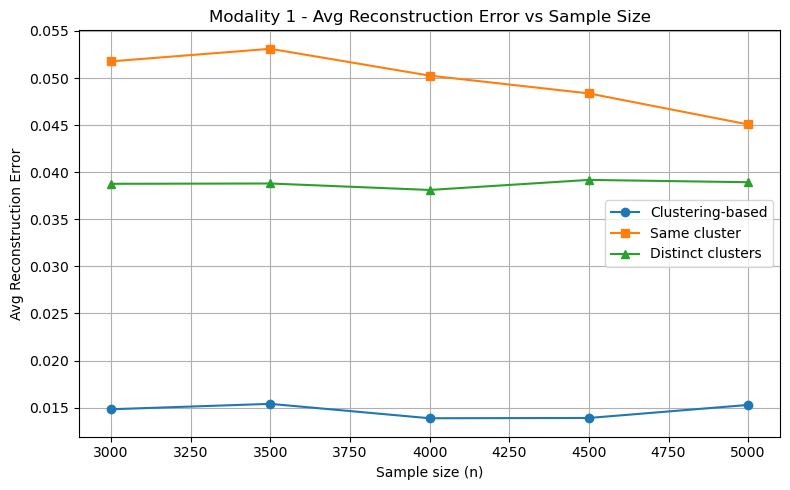

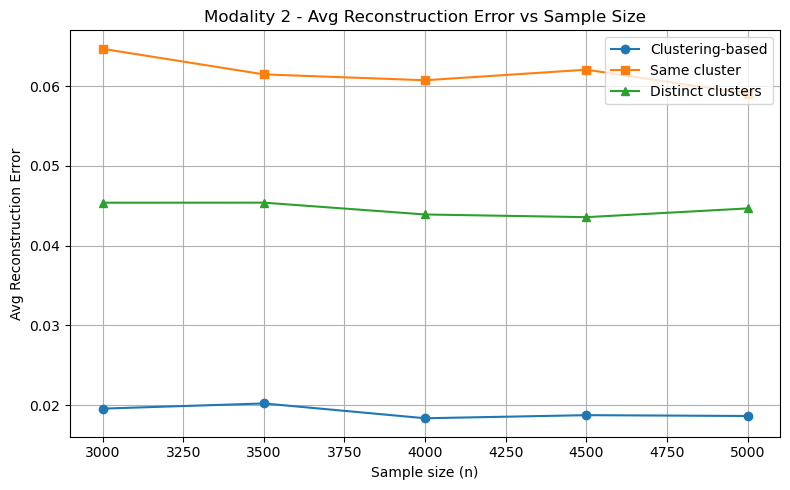

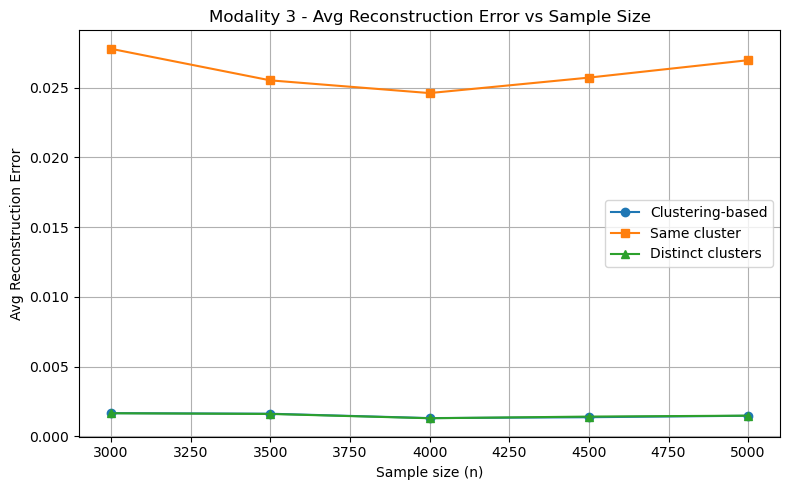

In [43]:
import matplotlib.pyplot as plt

# Unpack results
n_values_sorted = sorted(all_errors.keys())

# For each modality (0, 1, 2), prepare a plot
for modality_idx in range(3):
    clustered_errors = [all_errors[n]['clustered'][modality_idx] for n in n_values_sorted]
    same_errors = [all_errors[n]['same_cluster'][modality_idx] for n in n_values_sorted]
    distinct_errors = [all_errors[n]['distinct_clusters'][modality_idx] for n in n_values_sorted]

    plt.figure(figsize=(8, 5))
    plt.plot(n_values_sorted, clustered_errors, marker='o', label='Clustering-based')
    plt.plot(n_values_sorted, same_errors, marker='s', label='Same cluster')
    plt.plot(n_values_sorted, distinct_errors, marker='^', label='Distinct clusters')

    plt.title(f"Modality {modality_idx + 1} - Avg Reconstruction Error vs Sample Size")
    plt.xlabel("Sample size (n)")
    plt.ylabel("Avg Reconstruction Error")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"modality_{modality_idx + 1}_rec_error_vs_n.png")
    plt.show()

In [45]:
import pandas as pd

df = pd.DataFrame(all_errors)
df.to_csv('output_func_n_setup_1.csv', index=False)